# Code of the final analyses performed for the paper: 
Date: 20 July 2022<br>
Author: Roshan Rane<br>

## Meeting notes
Date: 30 June 2022 <br>
Attended: Milena and Kerstin<br>
Meeting notes:<br>
1. Get other variables of interest from Milena and run the analysis on them -> July 1st week
2. ~Why didnt controlling for ESPAD-Alc reduce it so much -> use age 22 instead of 18~
3. ~Control for binge variable itself or a noisy variant of it?~
4. Should I instead try testing it on my new 3D tool by training a neural network on the data?
5. We could not even predict personality vars from sMRI? Add additional plot to show this vs binge drinking
6. color the variables by categories
7. check smoking var used in Whelan paper


@Milena:
* Analysis 0 is where I preprocess all the missing confounds. You should check the distribution of these variables to see that the median binary threshold makes sense for them
* Ensure that the table Confounds_list_Milena.xlsx has no '???' or empty cells in columns ['colname', 'questionnaire', 'impute_missing_with','binarizing_threshold','category']
* In Analysis 1 I prepare the h5files. I have shown an example for the Imaging-at-BL-onset0 h5file. It would be helpful if you take a look at all the output msgs and distributions once, just in case I missed something. 
* Thank you :)

In [1]:
# standard python packages
import os, sys
from glob import glob
from os.path import join 
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
from scikits.bootstrap import ci

import seaborn as sns
sns.set(style="whitegrid", context='paper', color_codes=False)
sys.path.append("../MLpipelines")
from plotResults import *

import h5py
import random

In [2]:
H5_DIR = "/ritter/share/data/IMAGEN/h5files/"
CONF_DATA_DIR = "/ritter/share/data/IMAGEN/posthoc/"
RESULTS_DIR = "/ritter/roshan/workspace/ML_for_IMAGEN/MLpipelines/results/"

In [3]:
H5_FILES = {
    "h5causal0" : "newlbls-clean-bl-espad-fu3-19a-binge-causal-onset0-n477.h5",
    "h5causal1" : "newlbls-clean-bl-espad-fu3-19a-binge-causal-onset1-n565.h5",
    # Take the 3 h5files used in paper
    "h5fu3" : "newlbls-clean-fu3-espad-fu3-19a-binge-n650.h5",
    # "h5fu2" : "newlbls-clean-fu2-espad-fu3-19a-binge-n634.h5",
    # "h5bl" : "newlbls-clean-bl-espad-fu3-19a-binge-n620.h5",
}

## Useful helper functions

### H5 file inspection funcs

In [4]:
def plot_dists(h5, lbl, col_names, suptitle=''):
    
    df = pd.DataFrame({c:h5[c][()] for c in [lbl]+col_names})
    df.index = h5["i"][()]
    
    if len(df[lbl].unique())>2:
        print("lbl has more than 2 states and in range [{}, {}, {}] \n aborting distribution plots .....".format(
                df[lbl].min(), df[lbl].mean(), df[lbl].max())) 
    else:        
        f, axes = plt.subplots(1, len(col_names)+1, figsize=(4*(len(col_names)+1), 3))
        if suptitle: plt.suptitle(suptitle)

        val = dict(df[lbl].astype(int).astype('str').value_counts())
        axes[0].pie(list(val.values()), labels = list(val.keys()), autopct='%1.0f%%', shadow=True, startangle=90) 
        axes[0].axis('equal')

        for ax, c in zip(axes[1:], col_names):
            if len(df[c].unique())<=10: # then bar plot
                dfi = df[[c,lbl]].value_counts(dropna=False).unstack().sort_index()

                dfi.sort_index().plot.bar(
                    stacked=True, title=c, legend=True, 
                    alpha=0.5, sort_columns=True, 
                    grid=True, rot=90, ax=ax, width=0.9)
    #             for i, x in enumerate(dfi.values):
    #                 ax.text(i, x+(x/100)+1, str(x))

            else: # histogram
                for lbl_i, dfi in df.groupby(lbl):
                    lbl_i = int(lbl_i)
                    dfi[c].plot.hist(label="lbl="+str(lbl_i), title=c,
                                     grid=True, alpha=0.5, legend=True, bins=10, ax=ax)

        plt.legend()   
        plt.show()

def check_h5_contents(H5_FILES, ignore=''):
    
    if isinstance(H5_FILES, str): H5_FILES = [H5_FILES]
    
    for k, h5_files_glob in enumerate(H5_FILES):
        
        for h5_file in glob(h5_files_glob):
            print("______________________________________________________________________________________")
            if ignore and ignore in h5_file:
                print(f"ignoring '{h5_file}' because of the ignore str '{ignore}'")
            else:            
                with h5py.File(h5_file, 'r') as h5:
                    print("filename: {} \n h5.columns = {} \n h5.attrs = {}".format(
                        h5_file.split("/")[-1], list(h5.keys()), list(h5.attrs.keys())))

                    try:
                        n = len(h5["i"])
                        y = h5.attrs['labels'][0]
                        conf_names=h5.attrs["confs"].tolist()
                        print("n = {} \t label = {} \t X.shape = {}  \t confs = {}".format( 
                            n, y, h5["X"].shape, conf_names))

                        # plot the confs and label distributions in the data
                        print("label and conf with distributions:")
                        plot_dists(h5, y, conf_names)

                    except Exception as e:  print(e) 

                    # plot a random subject's brain image in the data 
                    random_i = random.randint(0, n-1)
                    img = h5["X"][random_i]
                    print("\nsubject: {} \t (min={:.2f}, mean={:.2f}, max={:.2f})".format(
                        h5["i"][random_i], img.min(), img.mean(), img.max()))
                    
                    for conf in  conf_names:
                        if conf not in ['sex','site']:
                            print(f"conf {conf} == label {y} ? \t True for n={np.sum(h5[conf][:]==h5[y][:])}/{n}")

In [5]:
def print_h5_for_MLpipeline(h5_dir=H5_DIR, filter_func=lambda filename: 'posthoc-cc-bl' in filename and 'causal' in filename):
    
    # print(f"  DATA_DIR + 'h5files/{ori_h5_file}',")
    for h5file in os.listdir(h5_dir):
        if filter_func(h5file):
            print(f"  DATA_DIR + 'h5files/{h5file}',")

### attach conf to H5 files

In [6]:
# add binge itself as a conf
def attach_conf_fromseries(H5_DIR, to_h5, conf, prepend='h5causal1', print_all=True):
    
    # create a new h5 file name
    out_h5 = '-'.join(['posthoc-cc2',prepend,conf.name])+'.h5'
    if print_all: print("writing to ..", out_h5)
    assert not os.path.exists(H5_DIR+out_h5), "[ERROR] file already exists.. skipping h5file creation. Remove it manually first"

    try:
        with h5py.File(H5_DIR+out_h5, 'w') as data_out:
            # first just copy all h5 file data to new h5 file    
            with h5py.File(H5_DIR+to_h5, 'r') as data_dest:
                for dataset in data_dest:
                    data_out.create_dataset(dataset, data=data_dest[dataset]) 
                for attr in data_dest.attrs:
                    data_out.attrs[attr]=data_dest.attrs[attr]

            # now add the confound
            if conf.name not in data_out.attrs['confs']:

                if print_all: print(f"attaching conf {conf.name}")
                data_out.attrs['confs'] = list(data_out.attrs['confs'])+[conf.name]
                # align the subject IDs to fill the right conf value for each subject in the h5
                h5_sub_ids = data_out['i'][:]
                # below script works only if the IDs in src data h5 are arranged in an ascending order
                assert np.all(h5_sub_ids[:-1] <= h5_sub_ids[1:]), f"subject IDs in {to_h5} are not in ascending order.. change the algo below ?!"
                conf = conf.sort_index()
                h5_sub_ids_in_conf = np.argwhere(np.isin(h5_sub_ids, conf.index)).ravel()
                conf_sub_ids_in_h5 = np.argwhere(np.isin(conf.index, h5_sub_ids)).ravel()
                assert len(h5_sub_ids_in_conf)==len(conf_sub_ids_in_h5)
                data_out.create_dataset(conf.name, data=conf.iloc[conf_sub_ids_in_h5]) 

                # check if the distribution of confound is acceptable
                for val,counts in conf.iloc[conf_sub_ids_in_h5].value_counts().iteritems():
                    assert counts>=0.1*len(conf_sub_ids_in_h5), f"\
    the value {val} in {conf.name} has fewer than 10% instances (n={counts}) which is very small for counter balancing to work"

                # remove subject IDs missing the conf info
                if len(h5_sub_ids_in_conf)<len(h5_sub_ids):

                    print(f"[WARN] only {len(h5_sub_ids_in_conf)} sub IDs were found for this conf data, out of {len(h5_sub_ids)}")
                    existing_datasets = list(data_out.keys())
                    existing_datasets.remove(conf.name)
                    if print_all: print(f"Removing subjects with missing value from {existing_datasets}")
                    for existing_dataset in existing_datasets:
                        new_data = data_out[existing_dataset][h5_sub_ids_in_conf] 
                        del data_out[existing_dataset] 
                        data_out.create_dataset(existing_dataset, data=new_data) 

    except Exception as e:
        if os.path.isfile(H5_DIR+out_h5): os.remove(H5_DIR+out_h5)
        raise e

In [7]:
def attach_conf_fromh5(H5_DIR, from_h5, to_h5, print_all=True):
    
    # create a new h5 file name
    out_h5 = "-".join(from_h5.split('-')[:-1])+"-"+ "-".join(to_h5.split('-')[-4:])
    if print_all: print("writing to ..", out_h5)
    
    with h5py.File(H5_DIR+out_h5, 'w') as data_out:
        # first just copy all h5 file data to new h5 file    
        with h5py.File(H5_DIR+to_h5, 'r') as data_dest:
            for dataset in data_dest:
                data_out.create_dataset(dataset, data=data_dest[dataset]) 
            for attr in data_dest.attrs:
                data_out.attrs[attr]=data_dest.attrs[attr]
            
        # now add the confound
        with h5py.File(H5_DIR+from_h5, 'r') as data_src:
                for dataset in data_src:
                    if dataset not in data_out:
                        if print_all: print(f"attaching conf {dataset}")
                        data_out.attrs['confs'] = list(data_out.attrs['confs'])+[dataset]
                        # match subject IDs
                        src_sub_ids = data_src['i'][:]
                        out_sub_ids = data_out['i'][:]
                        # ASSUMPTION: the src_sub_ids is sorted in ascending order of IDs
                        valid_idx = np.argwhere(np.in1d(src_sub_ids, out_sub_ids)).squeeze()
                        data_out.create_dataset(dataset, data=data_src[dataset][valid_idx]) 
                        
                        if len(valid_idx)<len(out_sub_ids):
                            print(f"[WARN] only {len(valid_idx)} sub IDs were found for this conf data, out of {len(out_sub_ids)}")
                            existing_datasets = list(data_out.keys())
                            existing_datasets.remove(dataset)
                            # if print_all: print(f"Removing subjects with missing value from {existing_datasets}")
                            for existing_dataset in existing_datasets:
                                valid_idx_2 =  np.argwhere(np.in1d(out_sub_ids, src_sub_ids)).squeeze()
                                new_data = data_out[existing_dataset][valid_idx_2] 
                                del data_out[existing_dataset] 
                                data_out.create_dataset(existing_dataset, data=new_data) 
                            

### Result helper funcs

In [8]:
def std_dev_diff(scores1, scores2):
    std_dev = ((scores1.values-scores2.values) - (scores1.mean() - scores2.mean())) / (((scores1.std()**2)/len(scores1) + (scores2.std()**2)/len(scores2))**(1/2))
    # print(std_dev)
    return std_dev.mean()

def create_accuracy_csv(fil_name='', save_df=False):
    
    map_fil_to_blh5 = {'h5causal1': RESULTS_DIR+"/newlbls-clean-bl-espad-fu3-19a-binge-causal-onset1-n565/20220726-1119/run.csv",
                       'h5causal0': RESULTS_DIR+"/newlbls-clean-bl-espad-fu3-19a-binge-causal-onset0-n477/20220414-1352/run.csv",
                       'h5fu3': RESULTS_DIR+"/newlbls-clean-fu3-espad-fu3-19a-binge-n650/20211026-1911/run.csv",
                       'h5fu2': RESULTS_DIR+"/newlbls-clean-fu2-espad-fu3-19a-binge-n634/20210618-1701/run.csv",
                       'h5bl': RESULTS_DIR+"/newlbls-clean-bl-espad-fu3-19a-binge-n620/20211026-1810/run.csv",
                      }
    
    df_out = pd.DataFrame()

    for resultfile in glob(f"../MLpipelines/results/posthoc-cc2*{fil_name}*/*/run.csv"):

        df = pd.read_csv(resultfile)    
        conf_name = list(df.o.unique())
        [conf_name.remove(remove) for remove in ['X','Binge', 'sex', 'site'] if remove in conf_name]
        assert len(conf_name)==1, conf_name+" list should have only the new confound"
        conf_name=conf_name[0]
        
        for model, dfi in df.groupby('model'):
            
            df_out_i = {'Confound':conf_name.title(), 
                        'TP':'BL', 
                        'Model':model,
                        'h5name':resultfile.split('/')[-3]}
            
            if 'baseline-cb' in dfi['technique'].unique():
                dfi_bl = dfi.loc[(dfi['io'] == 'X-Binge') & (dfi['technique'] == 'baseline-cb')]
            else:
                dfi_bl = pd.read_csv(map_fil_to_blh5[fil_name]).groupby('model').get_group(model)
                baseline_cb = 'cb' if 'baseline-cb' not in dfi['technique'].unique() else 'baseline-cb'
                dfi_bl = dfi_bl.loc[(dfi_bl['io'] == 'X-Binge') & (dfi_bl['technique'] == baseline_cb)]                
                
            df_out_i.update({'Accuracy BL':  dfi_bl['test_score'].mean()})
            df_out_i.update({'Std-Dev BL':   dfi_bl['test_score'].std()})

            dfi_conf = dfi.loc[(dfi['io'] == 'X-Binge') & (dfi['technique'] == 'cb')]
            df_out_i.update({'Accuracy CB':   dfi_conf['test_score'].mean()})
            df_out_i.update({'Std-Dev CB':    dfi_conf['test_score'].std()})
            
            df_out_i.update({'Accuracy Diff CB - BL':  (dfi_conf['test_score'].mean() - dfi_bl['test_score'].mean())})
            df_out_i.update({'Std-Dev Diff CB - BL':  std_dev_diff(dfi_conf['test_score'], dfi_bl['test_score'])})
            
            # display(df_out_i)
            df_out = df_out.append(df_out_i, ignore_index=True)
            
    if save_df: df_out.to_csv(f"results/accuracy{fil_name}.csv", index=False)
    return df_out

In [9]:
def plot_accuracy_csv(df):

    fig, axes = plt.subplots(1, 2, 
                             sharex=False, sharey=True, 
                             constrained_layout=True,
                             figsize=(4*len(df[['Confound','h5name']].nunique()), 16))   
    fs=12
    if isinstance(df,str): df = pd.read_csv(f'results/accuracy-{df}.csv')

    df = df.loc[(df['Model'].isin(['SVM-rbf','GB']))].sort_values(
        ['Accuracy Diff CB - BL','Confound'], ascending=False)
    # display(df)
    
    # multiply values by 100 for percent
    for col in df:
        if 'accuracy' in col.lower() or 'std' in col.lower(): 
            df[col] = df[col]*100
            
    # if there are more than 1 h5files in the accuracy df then mention the h5file name in the xticks
    # if 'h5name' in df and df.h5name.nunique()>1:        
    #     df['Confound'] = df['Confound'].str.cat(
    #             df['h5name'].apply(lambda x: '('+''.join(x.split('-')[-2:])+')'), sep='\n')
    
    # predetermine colors for each model
    colors = {m :plt.get_cmap('tab10')(i) for i,m in enumerate(df['Model'].unique())}
    # 1) plot absolute accuracies on X axis - baseline     
    for i, (model, df_i) in enumerate(df.groupby('Model')): 
        diff_style_args = dict(color=colors[model][:-1]+(0.2,), 
                               edgecolor=colors[model][:-1]+(1.,)) 
        df_i.plot(kind='barh',
            y="Accuracy BL", x='Confound', 
            # xerr="Std-Dev BL",
            width=0.2, position=1.3*i, label=None, 
            ax=axes[0],
            **diff_style_args)
    # add patch lines
    for bar in axes[0].patches:
        bar.set_hatch('\\\\\\\\')
        
    # 2) plot absolute accuracies on X axis - corrected 
    for i, (model, df_i) in enumerate(df.groupby('Model')): 
        df_i.plot(kind='barh',
            y="Accuracy CB", x='Confound', 
            xerr="Std-Dev CB",
            width=0.2, position=1.3*i, label=model, 
            ax=axes[0],
            color=colors[model], alpha=1)
    
     # 3) plot decrease/difference in accuracy on X axis
    for i, (model, df_i) in enumerate(df.groupby('Model')):  
        diff_style_args = dict(color=colors[model][:-1]+(0.2,), 
                               edgecolor=colors[model][:-1]+(1.,)) 
        df_i.plot(kind='barh',
            y="Accuracy Diff CB - BL", x='Confound',  sort_columns=True,
            xerr="Std-Dev Diff CB - BL", 
            width=0.2, position=1.3*i, label=model, 
            ax=axes[1], 
            **diff_style_args)
        axes[1].axvline(0,color='k', ls='--')
        
    # add patch lines
    for bar in axes[1].patches:
        bar.set_hatch('\\\\\\\\')
                
    # adjust legend of axes[0]
    hdls, lbls = axes[0].get_legend_handles_labels()
    axes[0].get_legend().remove()
    axes[1].legend(hdls,
                   [lbls[2]+' (before \ncorrection)',
                    lbls[3]+'\n(before \ncorrection)', 
                    lbls[2]+' (after \ncorrection)',
                    lbls[3]+'\n(after \ncorrection)'],
                   fontsize=fs-1, loc=[1.1,0.9])
    
    
    plt.suptitle("Model accuracies before and after correction", fontsize=fs+2)
    axes[0].set_title(f'Absolute accuracy (%)', fontsize=fs)
    axes[0].set_xlabel(f'Absolute accuracy (%)', fontsize=fs)
    axes[0].set_xlim([50,75])
    axes[1].set_title(f'(%) reduction in accuracy', fontsize=fs)
    axes[1].set_xlabel(f'(%) reduction in accuracy', fontsize=fs)
    axes[1].set_xlim([-10,10])
    axes[0].grid(False)
    axes[1].grid(False)
    
    # plt.tight_layout()

## Analysis 0: prepare missing covariate data
Prepare `all_*.csv` files for confounds that are missing this info. <br>
Extract all_* tables from raw tables.  <br>
Some confound information need to be extracted from the tables provided by IMAGEN.

In [10]:
df_confs = pd.read_excel("Confounds_list_Milena.xlsx")
print("Rows that need to be preprocessed n =", len(df_confs.dropna(subset=['raw questionnaire'])))
# df_confs.dropna(subset=['raw questionnaire'])[['time_point','raw questionnaire', 'score computation']]

Rows that need to be preprocessed n = 45


In [11]:
RAW_Q_DIR = '/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7'

def get_col_raw_df(loc, df_confs=df_confs):
    row = df_confs.loc[loc]
    tp, quest, formula = row[['time_point','raw questionnaire','score computation']]
    sep='\t' if 'dawba' in quest.lower() else ','
    df_raw = pd.read_csv((RAW_Q_DIR+quest), sep=sep)
    # convert user code to subject ID 
    if ('User code' in df_raw):
        df_raw.index = df_raw['User code'].astype(str).apply(lambda x: int(x.replace("-C", "").replace("-I", "").replace("-P", "")))

    df_raw.index.name = 'ID'
    return df_raw, tp, quest, formula

In [640]:
# check if all of them exist and have valid subject ID columns 
for i, row in df_confs.dropna(subset=['raw questionnaire']).iterrows():
    print(i, row['time_point'], row['raw questionnaire'])
    try:
        df_raw, tp, quest, formula = get_col_raw_df(i)
        # print(row['score computation'])
        # display(df_raw)
    except Exception as E:
        print(f'[ERROR {E.__class__.__name__}]', E)

30 BL /BL/psytools/IMAGEN-IMGN_PDS_RC5-IMAGEN_DIGEST.csv
31 BL /BL/psytools/IMAGEN-IMGN_ESPAD_CHILD_RC5-IMAGEN_DIGEST.csv
32 BL /BL/dawba/IMAGEN_dawba_BL.tsv


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  """


33 BL /BL/psytools/IMAGEN-IMGN_TLFB_RC5-BASIC_DIGEST.csv
34 BL /BL/psytools/IMAGEN-IMGN_ESPAD_CHILD_RC5-IMAGEN_DIGEST.csv
47 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DtypeWarning: Columns (104,107,183,184,194,269,274,360,363,370,372,443,450,520,530,904,907) have mixed types.Specify dtype option on import or set low_memory=False.
  """


48 FU3 /FU3/psytools/IMAGEN-IMGN_TLFB_FU3-IMAGEN_DIGEST.csv
49 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
50 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
51 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
52 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
53 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
54 FU3 /FU3/psytools/IMAGEN-IMGN_CSI_FU3.csv
55 FU3 /FU3/psytools/IMAGEN-IMGN_IRI_FU3.csv
56 FU3 /FU3/psytools/IMAGEN-IMGN_RRS_FU3.csv
57 FU3 /FU3/psytools/IMAGEN-IMGN_VIDGAME_FU3.csv
58 FU3 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv
59 FU3 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv
60 FU3 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv
61 FU3 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv
62 FU3 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv
63 FU3 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv
64 FU3 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv
68 FU3 /FU3/psytools/IMAGEN-IMGN_URBANICITY_FU3.csv
71 FU3 /FU3/psytools/IMAGEN-IMGN_WHO5_FU3.csv
84 FU3 /FU3/psytools/IMAGEN-IMGN_HF_FU3.csv
85 FU3 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv
86 FU3 /FU

##### all_PDS 
30 BL /BL/psytools/IMAGEN-IMGN_PDS_RC5-IMAGEN_DIGEST.csv

In [266]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(30)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2208 entries, 1274 to 99954902
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   User code            2208 non-null   object 
 1   Iteration            2208 non-null   int64  
 2   Language             2206 non-null   object 
 3   Completed            2208 non-null   object 
 4   Completed Timestamp  2208 non-null   object 
 5   Processed Timestamp  2208 non-null   object 
 6   Valid                2208 non-null   object 
 7   a10_f                1129 non-null   float64
 8   a10_m                1079 non-null   float64
 9   a11_f                1129 non-null   float64
 10  a11_m                1079 non-null   float64
 11  a12_m                1079 non-null   float64
 12  a12a_f               1129 non-null   float64
 13  a12b_f               1007 non-null   float64
 14  a13_f                1129 non-null   float64
 15  a13_m                1079 non-n

In [267]:
columns = sorted('a8_f + a9_f + a10_f + a11_f + a12a_f + a13_f + a8_m + a9_m + a10_m + a11_m + a12a_m + a13_m'.split(' + '))
columns
# @Milena some column names are like 'a12a_m' do not exist. I will sum all columns starting with 'a'

['a10_f',
 'a10_m',
 'a11_f',
 'a11_m',
 'a12a_f',
 'a12a_m',
 'a13_f',
 'a13_m',
 'a8_f',
 'a8_m',
 'a9_f',
 'a9_m']

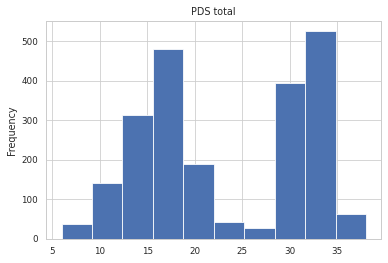

In [268]:
df_raw = df_raw.filter(regex='^a')
# correcting recode values a12a_f: 0 = 1, 1 = 4 @Milena what about a12b_f
df_raw.loc[:,'a12a_f'] = df_raw['a12a_f'].map({0:1,1:4})
# filling NaNs with 0 @Milena
df_raw = df_raw.fillna(0)
df_out = df_raw.sum(axis=1)
df_out.plot.hist(title='PDS total')
plt.show() #@Milena looks bimodal - might the total be different for differnt sex? Ex: Females have higher scores?

In [269]:
# prepare the all_PDS.csv
df_out.name = 'PDS Sum'
df_out = df_out.to_frame()
df_out['Session']=tp
df_out

,PDS Sum,Session
ID,,
1274,16.0,BL
22453,14.0,BL
75717,18.0,BL
106601,15.0,BL
106871,31.0,BL
...,...,...
99873252,31.0,BL
99875982,32.0,BL
99888850,12.0,BL


In [270]:
# save as all_PDS.csv
df_out.to_csv(CONF_DATA_DIR + "all_PDS.csv")

##### all_ESPAD
* 31 /BL/psytools/IMAGEN-IMGN_ESPAD_CHILD_RC5-IMAGEN_DIGEST.csv
* 34 /BL/psytools/IMAGEN-IMGN_ESPAD_CHILD_RC5-IMAGEN_DIGEST.csv
* 47 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv

In [549]:
df_raw, tp, quest, formula = get_col_raw_df(31)
quest, formula

('/BL/psytools/IMAGEN-IMGN_ESPAD_CHILD_RC5-IMAGEN_DIGEST.csv',
 "sum score 'bully': bully05 + bully06 + bully07 + bully08 + bully11 + bully12; sum score 'victim': bully01 + bully02 + bully03 + bully04 + bully09 + bully10")

In [550]:
_, tp2, quest2, formula2 = get_col_raw_df(34)
assert tp==tp2 and quest==quest2
formula2

"use item 6 as measure for smoking: 'On how many occasions during your lifetime have you smoked cigarettes?'"

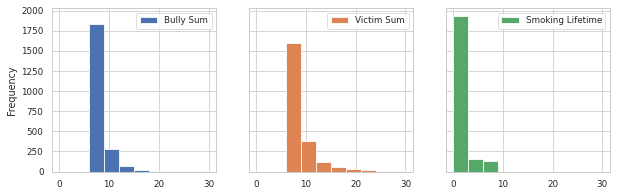

In [551]:
bully_cols = 'bully05 + bully06 + bully07 + bully08 + bully11 + bully12'.split(' + ')
victim_cols = 'bully01 + bully02 + bully03 + bully04 + bully09 + bully10'.split(' + ')

df_out = df_raw[bully_cols].sum(1)
df_out.name = 'Bully Sum'
df_out = df_out.to_frame()
df_out['Victim Sum'] = df_raw[victim_cols].sum(1)
df_out['Smoking Lifetime'] = df_raw['6']

df_out.plot.hist(subplots=True, sharey=True, layout=(1,3), figsize=(10,3))
plt.show() # @Milena

In [552]:
df_out['Session'] = tp
df_out

,Bully Sum,Victim Sum,Smoking Lifetime,Session
ID,,,,
1274,6,11,0,BL
22453,7,10,6,BL
75717,8,8,6,BL
106601,6,8,0,BL
106871,6,8,0,BL
...,...,...,...,...
99873252,6,6,2,BL
99875982,8,9,0,BL
99888850,6,6,0,BL


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (104,107,183,184,194,269,274,360,363,370,372,443,450,520,530,904,907) have mixed types.Specify dtype option on import or set low_memory=False.
  


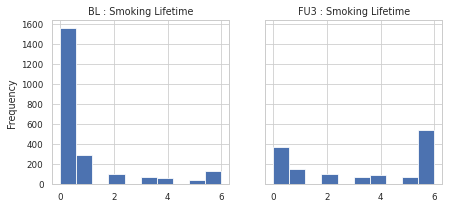

In [553]:
# add the FU3 smoking data
df_raw, tp, quest, formula = get_col_raw_df(47)
df_out2 = df_raw['6']
df_out2.name = 'Smoking Lifetime'
df_out2 = df_out2.to_frame()
df_out2['Session'] = tp
# print(len(df_out2))
df_out = df_out.append(df_out2)
# how did smoking behavior change from BL to FU3?
f, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=(7,3))
for i, (session,g) in enumerate(df_out.groupby('Session')):
    g['Smoking Lifetime'].plot.hist(title=session+' : Smoking Lifetime', ax=axes[i])
plt.show()

In [554]:
df_out.to_csv(CONF_DATA_DIR+"all_ESPAD.csv")

##### all_ESPAD_Alc
* 49 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
* 50 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
* 51 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
* 52 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
* 53 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv

In [354]:
#read the raw data
formulas=[]
for i, loc in enumerate([49,50,51,52,53]):
    df_raw, tp, quest, formula = get_col_raw_df(loc)
    if i>0:assert tp_old==tp and quest_old==quest
    formulas.append(formula)
    tp_old=tp
    quest_old=quest
    print(loc, quest, formula)

/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DtypeWarning: Columns (104,107,183,184,194,269,274,360,363,370,372,443,450,520,530,904,907) have mixed types.Specify dtype option on import or set low_memory=False.
  after removing the cwd from sys.path.


49 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv sum score = dmq03, dmq05, dmq11, dmq14, dmq16
50 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv sum score = dmq01, dmq04, dmq06, dmq15, dmq17
51 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv sum score = dmq07, dmq09, dmq10, dmq13, dmq18
52 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv sum score = dmq02, dmq08, dmq12, dmq19, dmq20
53 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv sum score = rapi01 + rapi02 + rapi03 + rapi04 + rapi05 + rapi06 + rapi07
+ rapi08 + rapi09 + rapi10 + rapi11 + rapi12 + rapi13 + rapi14 + rapi15 + rapi16 + rapi17 + rapi18 + rapi19 + rapi20 + rapi21 + rapi22 + rapi23


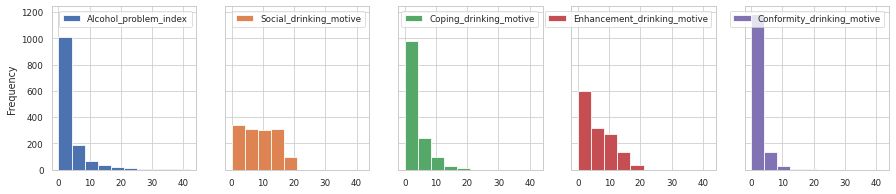

In [355]:
# prepare Alcohol_problem_index first
df_raw_rapi = df_raw["rapi01 + rapi02 + rapi03 + rapi04 + rapi05 + rapi06 + \
rapi07 + rapi08 + rapi09 + rapi10 + rapi11 + rapi12 + rapi13 + rapi14 + \
rapi15 + rapi16 + rapi17 + rapi18 + rapi19 + rapi20 + rapi21 + rapi22 + rapi23".split(' + ')]
df_raw_rapi = df_raw_rapi.fillna(0) #@Milena
df_out = df_raw_rapi.sum(1)
df_out.name = 'Alcohol_problem_index'
df_out = df_out.to_frame()

# now the remaining 4
other_cols = [
("Social_drinking_motive", 'dmq03, dmq05, dmq11, dmq14, dmq16'.split(', ')),
("Coping_drinking_motive", 'dmq01, dmq04, dmq06, dmq15, dmq17'.split(', ')),
("Enhancement_drinking_motive", 'dmq07, dmq09, dmq10, dmq13, dmq18'.split(', ')),
("Conformity_drinking_motive", 'dmq02, dmq08, dmq12, dmq19, dmq20'.split(', ')), 
]

for colname, cols in other_cols:
    df_raw_i = df_raw[cols]
    df_raw_i = df_raw_i.fillna(0) #@Milena
    df_out[colname] = df_raw_i.sum(1)
    
df_out.plot.hist(subplots=True, sharey=True, layout=(1,5), figsize=(15,3))
plt.show() # @Milena

In [356]:
df_out['Session'] = tp
df_out

,Alcohol_problem_index,Social_drinking_motive,Coping_drinking_motive,Enhancement_drinking_motive,Conformity_drinking_motive,Session
ID,,,,,,
112288,3.0,6.0,0.0,8.0,0.0,FU3
215284,1.0,6.0,1.0,0.0,0.0,FU3
240546,1.0,10.0,1.0,7.0,1.0,FU3
297685,4.0,5.0,1.0,3.0,1.0,FU3
308867,0.0,11.0,1.0,1.0,0.0,FU3
...,...,...,...,...,...,...
99677574,0.0,0.0,0.0,0.0,0.0,FU3
99873252,6.0,9.0,2.0,7.0,0.0,FU3
99875982,3.0,1.0,0.0,0.0,0.0,FU3


In [357]:
df_old = pd.read_csv(CONF_DATA_DIR+'all_ESPAD_Alc.csv')
df_out = pd.merge(df_old, df_out.reset_index(), on=['ID','Session'], how='outer')
df_out.set_index('ID').to_csv(CONF_DATA_DIR+'all_ESPAD_Alc.csv')

##### all_Eating
* 58 FU3 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv
* 59 FU3 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv
* 60 FU3 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv
* 61 FU3 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv
* 62 FU3 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv
* 63 FU3 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv
* 64 FU3 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv

In [400]:
#read the raw data of EDEQ first
formulas=[]
for i, loc in enumerate([58,59,60,61]):
    df_raw, tp, quest, formula = get_col_raw_df(loc)
    if i>0:assert tp_old==tp and quest_old==quest
    formulas.append(formula)
    tp_old=tp
    quest_old=quest
    print(loc, quest, formula)

58 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv mean score = sum(EDEQ_1, EDEQ_2, EDEQ_3, EDEQ_4, EDEQ_5)/5
59 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv mean score = sum(EDEQ_7, EDEQ_9, EDEQ_19, EDEQ_21, EDEQ_20)/5
60 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv mean score = sum(EDEQ_6, EDEQ_8, EDEQ_23, EDEQ_10,
EDEQ_26, EDEQ_27, EDEQ_28, EDEQ_11)/8
61 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv mean score = sum(EDEQ_22, EDEQ_24, EDEQ_8, EDEQ_25, EDEQ_12)/5


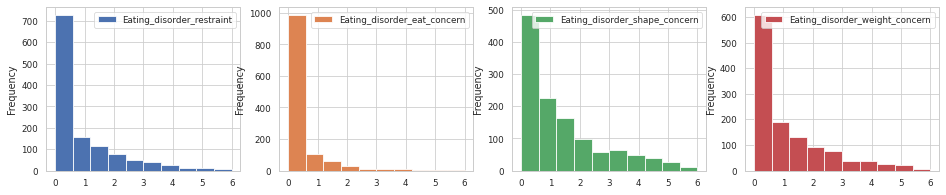

In [401]:
# prepare Eating_disorder_restraint first
df_raw_i = df_raw["EDEQ_1, EDEQ_2, EDEQ_3, EDEQ_4, EDEQ_5".split(', ')]
df_out = df_raw_i.mean(1)
df_out.name = 'Eating_disorder_restraint'
df_out = df_out.to_frame()
df_out

# now the remaining 3
other_cols = [
("Eating_disorder_eat_concern", 'EDEQ_7, EDEQ_9, EDEQ_19, EDEQ_21, EDEQ_20'.split(', ')),
("Eating_disorder_shape_concern", 'EDEQ_6, EDEQ_8, EDEQ_23, EDEQ_10, EDEQ_26, EDEQ_27, EDEQ_28, EDEQ_11'.split(', ')),
("Eating_disorder_weight_concern", 'EDEQ_22, EDEQ_24, EDEQ_8, EDEQ_25, EDEQ_12'.split(', '))
]

for colname, cols in other_cols:
    df_raw_i = df_raw[cols]
    df_raw_i = df_raw_i.fillna(0) #@Milena
    df_out[colname] = df_raw_i.mean(1)
    
df_out.plot.hist(subplots=True,  layout=(1,len(other_cols)+1), figsize=(4*len(other_cols)+4,3))
plt.show() # @Milena

In [402]:
#read the raw data of TFEQ first
formulas2=[]
for i, loc in enumerate([62,63,64]):
    df_raw2, tp, quest2, formula = get_col_raw_df(loc)
    if i>0:assert tp_old==tp and quest_old2==quest2
    formulas2.append(formula)
    tp_old=tp
    quest_old2=quest2
    print(loc, quest2, formula)

62 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv transformed sum score = [sum(TFEQ_2, TFEQ_11, TFEQ_12, TFEQ_15,
TFEQ_16,TFEQ_18) - 6] / 24 * 100
63 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv transformed sum score = [sum(TFEQ_1, TFEQ_4, TFEQ_5, TFEQ_7,
TFEQ_8, TFEQ_9, TFEQ_13, TFEQ_14, TFEQ_17) - 9] / 36 * 100
64 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv transformed sum score = [sum(TFEQ_3, TFEQ_6, TFEQ_10) - 3] / 12 * 100


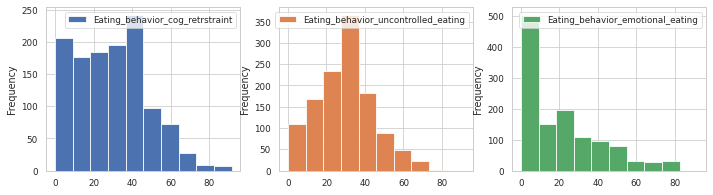

In [410]:
other_cols2 = [
("Eating_behavior_cog_retrstraint", 'TFEQ_2, TFEQ_11, TFEQ_12, TFEQ_15, TFEQ_16, TFEQ_18'.split(', ')),
("Eating_behavior_uncontrolled_eating", 'TFEQ_1, TFEQ_4, TFEQ_5, TFEQ_7, TFEQ_8, TFEQ_9, TFEQ_13, TFEQ_14, TFEQ_17'.split(', ')),
("Eating_behavior_emotional_eating", 'TFEQ_3, TFEQ_6, TFEQ_10'.split(', '))
]

for colname, cols in other_cols2:
    df_raw_i = df_raw2[cols]
    df_raw_i = df_raw_i.fillna(0) #@Milena
    df_out[colname] = 100*(df_raw_i.sum(1)-len(cols))/(4*len(cols))
    
df_out[list(list(zip(*other_cols2))[0])].plot.hist(subplots=True, layout=(1,len(other_cols2)+1), figsize=(4*len(other_cols)+4,3))
plt.show() # @Milena

In [411]:
df_out['Session'] = tp
df_out

,Eating_disorder_restraint,Eating_disorder_eat_concern,Eating_disorder_shape_concern,Eating_disorder_weight_concern,Eating_behavior_cog_retrstraint,Eating_behavior_uncontrolled_eating,Eating_behavior_emotional_eating,Session
ID,,,,,,,,
112288,0.0,0.0,0.000,0.8,0.000000,55.555556,0.000000,FU3
215284,1.6,1.0,5.125,4.0,50.000000,27.777778,58.333333,FU3
240546,0.4,0.0,1.375,0.8,37.500000,36.111111,50.000000,FU3
297685,1.8,0.2,1.625,0.4,29.166667,30.555556,50.000000,FU3
308867,0.0,0.0,0.125,0.2,41.666667,8.333333,0.000000,FU3
...,...,...,...,...,...,...,...,...
99616225,2.8,0.4,3.625,3.4,54.166667,2.777778,0.000000,FU3
99677574,0.0,0.0,0.250,0.0,12.500000,22.222222,8.333333,FU3
99873252,1.6,0.0,1.500,1.8,29.166667,16.666667,8.333333,FU3


In [412]:
df_out.to_csv(CONF_DATA_DIR+'all_Eating.csv')

##### all_QOL
* 85 FU3 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv
* 86 FU3 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv
* 87 FU3 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv
* 88 FU3 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv

In [416]:
#read the raw data
formulas=[]
for i, loc in enumerate([85,86,87,88]):
    df_raw, tp, quest, formula = get_col_raw_df(loc)
    if i>0:assert tp_old==tp and quest_old==quest
    formulas.append(formula)
    tp_old=tp
    quest_old=quest
    print(loc, quest, formula)

85 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv HRQOL_HDCM_1
86 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv HRQOL_HDCM_2
87 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv HRQOL_HDCM_3
88 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv HRQOL_HDCM_4


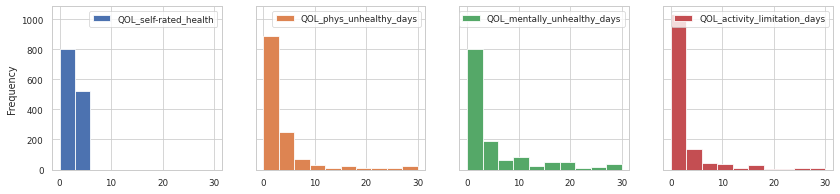

In [423]:
# prepare QOL_self-rated_health first
df_raw_i = df_raw["HRQOL_HDCM_1"]
df_raw_i.name = 'QOL_self-rated_health'
df_out = df_raw_i.to_frame()

# now the remaining 4
other_cols = [
("QOL_phys_unhealthy_days", 'HRQOL_HDCM_2'),
("QOL_mentally_unhealthy_days", 'HRQOL_HDCM_3'),
("QOL_activity_limitation_days", 'HRQOL_HDCM_4'),
]

for colname, cols in other_cols:
    df_out[colname] = df_raw[cols]
    
df_out.plot.hist(subplots=True, sharey=True, layout=(1,len(other_cols)+1), figsize=(4*len(other_cols)+2,3))
plt.show() # @Milena

In [424]:
df_out['Session'] = tp
df_out

,QOL_self-rated_health,QOL_phys_unhealthy_days,QOL_mentally_unhealthy_days,QOL_activity_limitation_days,Session
ID,,,,,
112288,1,0,0,0,FU3
215284,5,25,7,4,FU3
240546,1,0,0,0,FU3
297685,2,3,2,2,FU3
308867,2,0,0,0,FU3
...,...,...,...,...,...
99677574,2,2,0,2,FU3
99873252,2,1,1,0,FU3
99875982,2,0,0,0,FU3


In [425]:
df_out.to_csv(CONF_DATA_DIR+'all_QOL.csv')

##### all_CTS
* 111 BL /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv
* 112 BL /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv
* 113 BL /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv
* 114 BL /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv
* 115 BL /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv

In [643]:
#read the raw data
formulas=[]
for i, loc in enumerate([111,112,113,114,115]):
    df_raw, tp, quest, formula = get_col_raw_df(loc)
    print(loc, quest, formula)
    if i>0:assert tp_old==tp and quest_old==quest
    formulas.append(formula)
    tp_old=tp
    quest_old=quest


111 /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv cts_assault
112 /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv cts_injury
113 /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv cts_negotiation
114 /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv cts_psychological_aggression
115 /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv cts_secual_coercion


In [644]:
df_raw_i = df_raw["cts_assault"]
df_raw_i.name = 'Parent Assault Mean'
df_out = df_raw_i.to_frame()
# df_out.info()

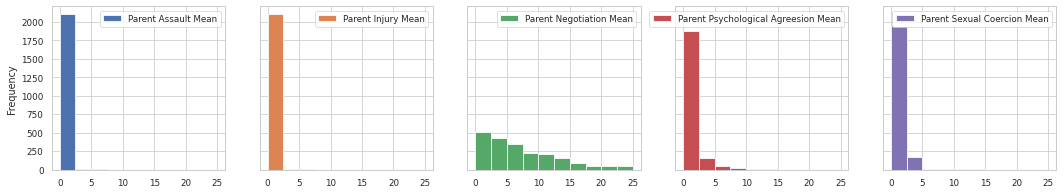

In [645]:
# now the remaining 4
other_cols = [
('Parent Injury Mean', 'cts_injury'),
('Parent Negotiation Mean', 'cts_negotiation'),
('Parent Psychological Agreesion Mean', 'cts_psychological_aggression'),
('Parent Sexual Coercion Mean', 'cts_sexual_coercion'),
]

for colname, cols in other_cols:
    df_out[colname] = df_raw[cols]
    
df_out.plot.hist(subplots=True, sharey=True, sharex=False, layout=(1,len(other_cols)+1), figsize=(4*len(other_cols)+2,3))
plt.show() # @Milena

In [646]:
df_out['Session'] = tp
df_out

,Parent Assault Mean,Parent Injury Mean,Parent Negotiation Mean,Parent Psychological Agreesion Mean,Parent Sexual Coercion Mean,Session
ID,,,,,,
1274,0.0,0.0,4.500000,0.875,0.000000,BL
22453,0.0,0.0,22.166667,3.625,4.166667,BL
75717,0.6,0.0,9.416667,10.000,0.000000,BL
106601,0.0,0.0,0.583333,0.125,0.000000,BL
106871,0.0,0.0,1.500000,0.500,0.000000,BL
...,...,...,...,...,...,...
99873252,0.0,0.0,8.333333,0.250,0.000000,BL
99875982,0.0,0.0,4.916667,0.250,0.000000,BL
99888850,0.0,0.0,1.500000,0.000,0.000000,BL


In [650]:
df_old = pd.read_csv(CONF_DATA_DIR+'all_CTS_NEW.csv')
df_out = pd.merge(df_old, df_out.reset_index(), on=['ID','Session'], how='outer')
df_out.set_index('ID').to_csv(CONF_DATA_DIR+'all_CTS.csv')

##### all_GEN
* 117 BL /BL/psytools/IMAGEN-IMGN_GEN_RC5-BASIC_DIGEST.csv

In [453]:
#read the raw data
formulas=[]
for i, loc in enumerate([117]):
    df_raw, tp, quest, formula = get_col_raw_df(loc)
    if i>0:assert tp_old==tp and quest_old==quest
    formulas.append(formula)
    tp_old=tp
    quest_old=quest
    print(loc, quest, formula)

117 /BL/psytools/IMAGEN-IMGN_GEN_RC5-BASIC_DIGEST.csv Psych_History (recode yes = 1, no = 0)


In [454]:
df_raw_i = df_raw["Psych_History"].map({'YES':1, 'NO':0, 'DK':np.nan, 'RF':np.nan}) #@Milena is it ok that I can map DK and RF as nans?
df_raw_i.name = 'Parent Psychiatric Disorders History'
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out.value_counts(dropna=False)

Parent Psychiatric Disorders History  Session
1.0                                   BL         1104
0.0                                   BL         1032
NaN                                   BL           55
dtype: int64

In [455]:
df_old = pd.read_csv(CONF_DATA_DIR+'all_GEN.csv')
df_out = pd.merge(df_old, df_out.reset_index(), on=['ID','Session'], how='outer')
df_out.set_index('ID').to_csv(CONF_DATA_DIR+'all_GEN.csv')

## Analysis 0: prepare missing covariates (iter 2)
Check which covariates are still pending preprocessing

In [655]:
df_confs = pd.read_excel("Confounds_list_Milena_v2.xlsx")
df_confs = df_confs.loc[df_confs['questionnaire'].str.contains('\?\?\?') | df_confs['colname'].str.contains('\?\?\?')]
print("Rows that need to be preprocessed n =", len(df_confs))
# df_confs.dropna(subset=['raw questionnaire'])[['time_point','raw questionnaire', 'score computation']]

# check if all of them exist and have valid subject ID columns 
for i, row in df_confs.iterrows():
    print(i, row['time_point'], row['raw questionnaire'])
    try:
        df_raw, tp, quest, formula = get_col_raw_df(i)
        # print(row['score computation'])
        # display(df_raw)
    except Exception as E:
        print(f'[ERROR {E.__class__.__name__}]', E)

Rows that need to be preprocessed n = 19
33 BL /BL/dawba/IMAGEN_dawba_BL.tsv
34 BL /BL/psytools/IMAGEN-IMGN_TLFB_RC5-BASIC_DIGEST.csv
49 FU3 /FU3/psytools/IMAGEN-IMGN_TLFB_FU3-IMAGEN_DIGEST.csv


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DtypeWarning: Columns (104,107,183,184,194,269,274,360,363,370,372,443,450,520,530,904,907) have mixed types.Specify dtype option on import or set low_memory=False.
  # Remove the CWD from sys.path while we load stuff.


55 FU3 /FU3/psytools/IMAGEN-IMGN_CSI_FU3.csv
56 FU3 /FU3/psytools/IMAGEN-IMGN_IRI_FU3.csv
57 FU3 /FU3/psytools/IMAGEN-IMGN_RRS_FU3.csv
58 FU3 /FU3/psytools/IMAGEN-IMGN_VIDGAME_FU3.csv
69 FU3 /FU3/psytools/IMAGEN-IMGN_URBANICITY_FU3.csv
[ERROR AttributeError] 'float' object has no attribute 'lower'
72 FU3 /FU3/psytools/IMAGEN-IMGN_WHO5_FU3.csv
[ERROR AttributeError] 'float' object has no attribute 'lower'
85 FU3 /FU3/psytools/IMAGEN-IMGN_HF_FU3.csv
108 FU3 /FU3/dawba/IMAGEN_dawba_FU3.tsv
109 FU3 /FU3/psytools/IMAGEN-IMGN_BULLY_FU3.csv
[ERROR AttributeError] 'float' object has no attribute 'lower'
111 BL /BL/psytools/IMAGEN-IMGN_ESPAD_PARENT_RC5-BASIC_DIGEST.csv
118 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv
119 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv
120 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv
121 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv
122 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv
[ERROR FileNotFoundError] [Errno 2] No such fi

##### all_SDQ
* 33 BL /BL/dawba/IMAGEN_dawba_BL.tsv
* 108 FU3 /FU3/dawba/IMAGEN_dawba_FU3.tsv

In [686]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(33, df_confs)
print(loc, quest, formula)
# df_raw

115 /BL/dawba/IMAGEN_dawba_BL.tsv recode items sobeys, sreflect, sattends, sfriend, spopular: 0 = 2, 1 = 1, 2 = 0; sum score = sconsid +  srestles + ssomatic + sshares + stantrum + sloner + sobeys + sworries + scaring + sfidgety + sfriend + sfights + sunhappy + spopular + sdistrac + sclingy + skind + slies + sbullied + shelpout + sreflect + ssteals + soldbest + safraid + sattends + sebddiff + schronic + sdistres + simphome + simpfrie + simpclas + simpleis + sburden + sebdtot + semotion + sconduct + shyper + speer + sprosoc + simpact


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  


In [687]:
df_raw = df_raw.reset_index().rename(columns={'level_0':'ID', 'level_1':'index'}).set_index('ID')

In [688]:
# recode items
for col in ['sobeys', 'sreflect', 'sattends', 'sfriend', 'spopular']:
    df_raw[col] = df_raw[col].map({0:2,1:1,2:0})

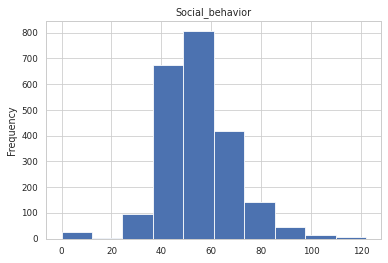

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2223 entries, 1274 to 99954902
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Social_behavior  2223 non-null   float64
 1   Session          2223 non-null   object 
dtypes: float64(1), object(1)
memory usage: 52.1+ KB


In [689]:
df_raw_i = df_raw["sconsid + srestles + ssomatic + sshares + stantrum + \
sloner + sobeys + sworries + scaring + sfidgety + sfriend + sfights + sunhappy + \
spopular + sdistrac + sclingy + skind + slies + sbullied + shelpout + sreflect + \
ssteals + soldbest + safraid + sattends + sebddiff + schronic + sdistres + simphome + \
simpfrie + simpclas + simpleis + sburden + sebdtot + semotion + sconduct + shyper + speer + sprosoc + simpact".split(" + ")].sum(1)

df_raw_i.name = 'Social_behavior'
df_raw_i.plot.hist(title=df_raw_i.name)
plt.show() # @milena 
df_out = df_raw_i.to_frame()
df_out['Session'] = tp 
df_out.info() 

In [690]:
#read the raw data
df_raw2, tp, quest, formula = get_col_raw_df(108, df_confs)
print(loc, quest, formula)
# df_raw2.columns

115 /FU3/dawba/IMAGEN_dawba_FU3.tsv recode items sobeys, sreflect, sattends, sfriend, spopular: 0 = 2, 1 = 1, 2 = 0; sum score = sconsid +  srestles + ssomatic + sshares + stantrum + sloner + sobeys + sworries + scaring + sfidgety + sfriend + sfights + sunhappy + spopular + sdistrac + sclingy + skind + slies + sbullied + shelpout + sreflect + ssteals + soldbest + safraid + sattends + sebddiff + schronic + sdistres + simphome + simpfrie + simpclas + simpleis + sburden + sebdtot + semotion + sconduct + shyper + speer + sprosoc + simpact


In [691]:
df_raw2 = df_raw2.reset_index().rename(columns={'level_0':'ID', 'level_1':'index'}).set_index('ID')

In [692]:
# recode items
for col in ['sobeys', 'sreflect', 'sattends', 'sfriend', 'spopular']:
    df_raw2[col] = df_raw2[col].map({0:2,1:1,2:0})

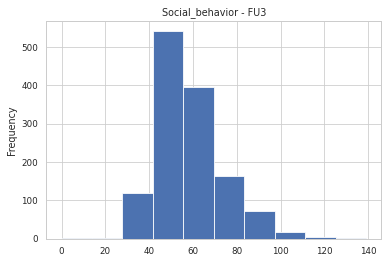

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1315 entries, 112288 to 99954902
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Social_behavior  1315 non-null   float64
 1   Session          1315 non-null   object 
dtypes: float64(1), object(1)
memory usage: 30.8+ KB


In [693]:
df_raw_i = df_raw2["sconsid + srestles + ssomatic + sshares + stantrum + \
sloner + sobeys + sworries + scaring + sfidgety + sfriend + sfights + sunhappy + \
spopular + sdistrac + sclingy + skind + slies + sbullied + shelpout + sreflect + \
ssteals + soldbest + safraid + sattends + sebddiff + schronic + sdistres + simphome + \
simpfrie + simpclas + simpleis + sburden + sebdtot + semotion + sconduct + shyper + speer + sprosoc + simpact".split(" + ")].sum(1)

df_raw_i.name = 'Social_behavior'
df_raw_i.plot.hist(title=df_raw_i.name+' - '+tp)
plt.show() # @milena 
df_out2 = df_raw_i.to_frame()
df_out2['Session'] = tp 
df_out2.info() 

In [696]:
df_out = df_out.append(df_out2)

In [697]:
df_out.to_csv(CONF_DATA_DIR+'all_SDQ.csv')

##### all_TLFB
* 34 BL /BL/psytools/IMAGEN-IMGN_TLFB_RC5-BASIC_DIGEST.csv
* 49 FU3 /FU3/psytools/IMAGEN-IMGN_TLFB_FU3-IMAGEN_DIGEST.csv

In [570]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(34)
print(loc, quest, formula)

49 /BL/psytools/IMAGEN-IMGN_TLFB_RC5-BASIC_DIGEST.csv following items indicate number of days usage per substance in past 30 days: tlfb_alcohol1, tlfb_tobacco1, tlfb_cannabis1, tlfb_inhalants1, tlfb_prescription1, tlfb_amphet1, tlfb_lsd1, tlfb_mushrooms1, tlfb_crack1, tlfb_cocaine1, tlfb_heroin1, tlfb_narcotics1, tlfb_ecstasy1, tlfb_ketamine1, tlfb_ghb1, tlfb_anabolic1, tlfb_other1; take alcohol and tobacco scores as separate variables each; add up remaining items to a drug use variable


In [579]:
# display(df_raw)
df_raw_i = df_raw["tlfb_cannabis1, tlfb_inhalants1, tlfb_prescription1, tlfb_amphet1, tlfb_lsd1, tlfb_mushrooms1, \
tlfb_crack1, tlfb_cocaine1, tlfb_heroin1, tlfb_narcotics1, tlfb_ecstasy1, \
tlfb_ketamine1, tlfb_ghb1, tlfb_anabolic1, tlfb_other1".split(', ')].sum(1)
df_raw_i.name = 'Drugs Last Month'
df_out = df_raw_i.apply(lambda x:x if x>=0 else np.nan).to_frame() # @Milena were are some negative values that I made NaN
df_out['Session'] = tp
# df_out.info()

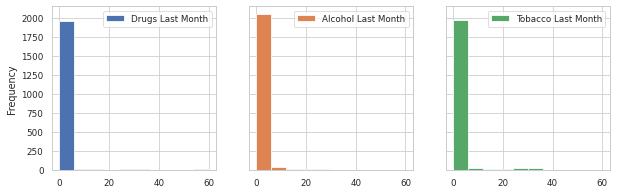

In [580]:
# now the remaining 4
other_cols = [
('Alcohol Last Month', 'tlfb_alcohol1'),
('Tobacco Last Month', 'tlfb_tobacco1'),
]

for colname, cols in other_cols:
    df_out[colname] = df_raw[cols].apply(lambda x:x if x>=0 else np.nan) # @Milena were are some negative values that I made NaN
    
df_out.plot.hist(subplots=True, sharey=True, layout=(1,len(other_cols)+1), figsize=(4*len(other_cols)+2,3))
plt.show() 

In [583]:
df_raw2, tp, quest, formula = get_col_raw_df(49)
print(loc, quest, formula)

49 /FU3/psytools/IMAGEN-IMGN_TLFB_FU3-IMAGEN_DIGEST.csv following items indicate number of days usage per substance in past 30 days: tlfb_alcohol1, tlfb_tobacco1, tlfb_cannabis1, tlfb_inhalants1, tlfb_prescription1, tlfb_amphet1, tlfb_lsd1, tlfb_mushrooms1, tlfb_crack1, tlfb_cocaine1, tlfb_heroin1, tlfb_narcotics1, tlfb_ecstasy1, tlfb_ketamine1, tlfb_ghb1, tlfb_anabolic1, tlfb_other1; take alcohol and tobacco scores as separate variables each; add up remaining items to a drug use variable


In [585]:
# display(df_raw)
df_raw2_i = df_raw2["tlfb_cannabis1, tlfb_inhalants1, tlfb_prescription1, tlfb_amphet1, tlfb_lsd1, tlfb_mushrooms1, \
tlfb_crack1, tlfb_cocaine1, tlfb_heroin1, tlfb_narcotics1, tlfb_ecstasy1, \
tlfb_ketamine1, tlfb_ghb1, tlfb_anabolic1, tlfb_other1".split(', ')].sum(1)
df_raw2_i.name = 'Drugs Last Month'
df_out2 = df_raw2_i.apply(lambda x:x if x>=0 else np.nan).to_frame() # @Milena were are some negative values that I made NaN
df_out2['Session'] = tp
# df_out2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1177 entries, 215284 to 99954902
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Drugs Last Month  1177 non-null   float64
 1   Session           1177 non-null   object 
dtypes: float64(1), object(1)
memory usage: 27.6+ KB


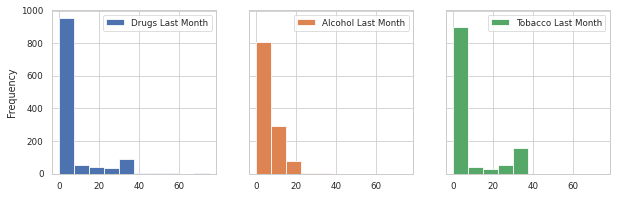

In [586]:
# now the remaining 4
other_cols = [
('Alcohol Last Month', 'tlfb_alcohol1'),
('Tobacco Last Month', 'tlfb_tobacco1'),
]

for colname, cols in other_cols:
    df_out2[colname] = df_raw2[cols].apply(lambda x:x if x>=0 else np.nan) # @Milena were are some negative values that I made NaN
    
df_out2.plot.hist(subplots=True, sharey=True, layout=(1,len(other_cols)+1), figsize=(4*len(other_cols)+2,3))
plt.show() 

In [591]:
df_out = df_out.append(df_out2)
df_out.to_csv(CONF_DATA_DIR+'all_TLFB.csv')

##### all_CSI
55 FU3 /FU3/psytools/IMAGEN-IMGN_CSI_FU3.csv

In [592]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(55)
print(loc, quest, formula)

49 /FU3/psytools/IMAGEN-IMGN_CSI_FU3.csv csi_sum


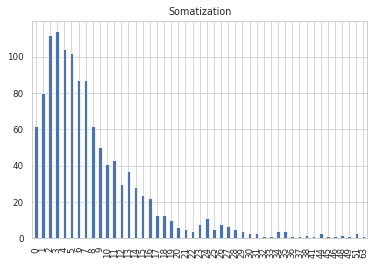

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1217 entries, 112288 to 99954902
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Somatization  1217 non-null   int64 
 1   Session       1217 non-null   object
dtypes: int64(1), object(1)
memory usage: 28.5+ KB


In [594]:
df_raw_i = df_raw['csi_sum']
df_raw_i.name = 'Somatization'
df_raw_i.value_counts().sort_index().plot.bar(title=df_raw_i.name)
plt.show() # @milena binarizing at median?
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out.info() 

In [595]:
df_out.to_csv(CONF_DATA_DIR+'all_CSI.csv')

##### all_IRI
56 FU3 /FU3/psytools/IMAGEN-IMGN_IRI_FU3.csv

In [596]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(56)
print(loc, quest, formula)

49 /FU3/psytools/IMAGEN-IMGN_IRI_FU3.csv sum score = IRI_fantasy + IRI_perspective + IRI_empathic + IRI_personal


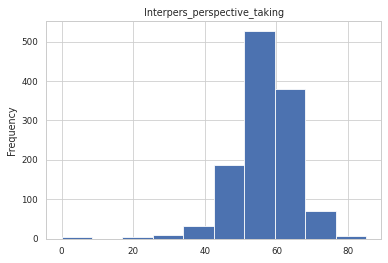

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1217 entries, 112288 to 99954902
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Interpers_perspective_taking  1217 non-null   int64 
 1   Session                       1217 non-null   object
dtypes: int64(1), object(1)
memory usage: 28.5+ KB


In [600]:
df_raw_i = df_raw['IRI_fantasy + IRI_perspective + IRI_empathic + IRI_personal'.split(' + ')].sum(1)
df_raw_i.name = 'Interpers_perspective_taking'
df_raw_i.plot.hist(title=df_raw_i.name)
plt.show() # @milena there are some outliers near 0
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out.info() 

In [601]:
df_out.to_csv(CONF_DATA_DIR+'all_ISI.csv')

##### all_RRS
57 FU3 /FU3/psytools/IMAGEN-IMGN_RRS_FU3.csv

In [602]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(57)
print(loc, quest, formula)

49 /FU3/psytools/IMAGEN-IMGN_RRS_FU3.csv sum score = sum(RRS_1, RRS_2, RRS_3, RRS_4, RRS_5, RRS_6, RRS_7,
RRS_8, RRS_9, RRS_10, RRS_11, RRS_12, RRS_13, RRS_14, RRS_15, RRS_16, RRS_17,
RRS_18, RRS_19, RRS_20, RRS_21, RRS_22


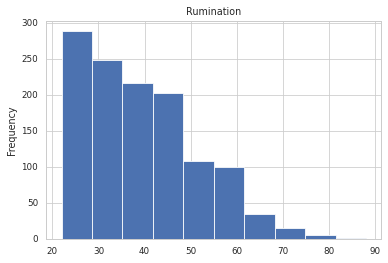

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1217 entries, 112288 to 99954902
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Rumination  1217 non-null   int64 
 1   Session     1217 non-null   object
dtypes: int64(1), object(1)
memory usage: 28.5+ KB


In [604]:
df_raw_i = df_raw['RRS_1, RRS_2, RRS_3, RRS_4, RRS_5, RRS_6, RRS_7, \
RRS_8, RRS_9, RRS_10, RRS_11, RRS_12, RRS_13, RRS_14, RRS_15, RRS_16, RRS_17, \
RRS_18, RRS_19, RRS_20, RRS_21, RRS_22'.split(', ')].sum(1)
df_raw_i.name = 'Rumination'
df_raw_i.plot.hist(title=df_raw_i.name)
plt.show() # @milena binary threshold median may not make sense?!
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out.info() 

In [601]:
df_out.to_csv(CONF_DATA_DIR+'all_RRS.csv')

##### all_VGS
58 FU3 /FU3/psytools/IMAGEN-IMGN_VIDGAME_FU3.csv

In [605]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(58)
print(loc, quest, formula)

49 /FU3/psytools/IMAGEN-IMGN_VIDGAME_FU3.csv only consider item VideoGame_2_1d: In the PAST 12 MONTHS On how many days per
week did you play?


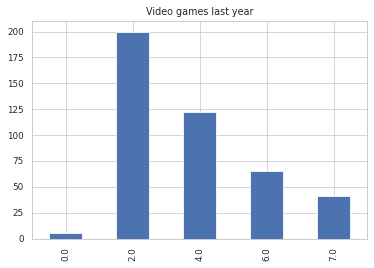

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1214 entries, 112288 to 99954902
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Video games last year  433 non-null    float64
 1   Session                1214 non-null   object 
dtypes: float64(1), object(1)
memory usage: 28.5+ KB


In [608]:
df_raw_i = df_raw['VideoGame_2_1d']
df_raw_i.name = 'Video games last year'
df_raw_i.value_counts().sort_index().plot.bar(title=df_raw_i.name)
plt.show() # @milena does the binary threshold median makes sense?!
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out.info() 

In [609]:
df_out.to_csv(CONF_DATA_DIR+'all_VGS.csv')

##### all_Urbanicity
69 FU3 /FU3/psytools/IMAGEN-IMGN_URBANICITY_FU3.csv

In [611]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(69)
print(loc, quest, formula)

49 /FU3/psytools/IMAGEN-IMGN_URBANICITY_FU3.csv weighted sum score = sum((URBANICITY_city*3), (URBANICITY_town*2),(URBANICITY_rural*1))


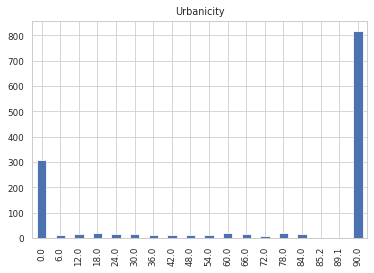

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1327 entries, 112288 to 99954902
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Urbanicity  1327 non-null   float64
 1   Session     1327 non-null   object 
dtypes: float64(1), object(1)
memory usage: 31.1+ KB


In [614]:
df_raw_i = (df_raw['URBANICITY_city']*3 +  df_raw['URBANICITY_city']*2 +  df_raw['URBANICITY_city']) 
df_raw_i.name = 'Urbanicity'
df_raw_i.value_counts().sort_index().plot.bar(title=df_raw_i.name)
plt.show() # @milena does the binary threshold median makes sense?!
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out.info() 

In [615]:
df_out.to_csv(CONF_DATA_DIR+'all_Urbanicity.csv')

##### all_WHO
72 FU3 /FU3/psytools/IMAGEN-IMGN_WHO5_FU3.csv

In [626]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(72)
print(loc, quest, formula)

49 /FU3/psytools/IMAGEN-IMGN_WHO5_FU3.csv transformed sum score = sum(WHO5_1 to WHO5_5) * 4


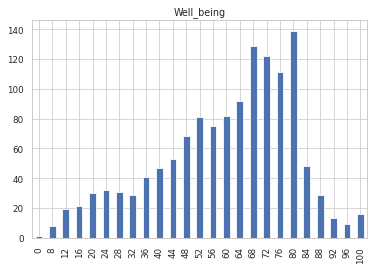

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1326 entries, 112288 to 99954902
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Well_being  1326 non-null   int64 
 1   Session     1326 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.1+ KB


In [627]:
df_raw_i = df_raw.filter(regex='WHO').sum(1)*4 # @Milena is it x4 or x5?
df_raw_i.name = 'Well_being'
df_raw_i.value_counts().sort_index().plot.bar(title=df_raw_i.name)
plt.show() # @milena should the binary threshold be greater than median or lower than median ?
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out.info() 

In [628]:
df_out.to_csv(CONF_DATA_DIR+'all_WHO.csv')

##### all_HF
85 FU3 /FU3/psytools/IMAGEN-IMGN_HF_FU3.csv

In [631]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(85)
print(loc, quest, formula)
# df_raw.columns

49 /FU3/psytools/IMAGEN-IMGN_HF_FU3.csv sum score any physical condition = sum(HF_08 to HF_18)


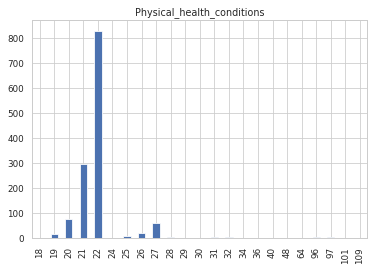

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1322 entries, 112288 to 99954902
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Physical_health_conditions  1322 non-null   int64 
 1   Session                     1322 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.0+ KB


In [632]:
df_raw_i = df_raw["'HF_08', 'HF_09', 'HF_10', 'HF_11', \
'HF_12', 'HF_13', 'HF_14', 'HF_15', 'HF_16', 'HF_17', 'HF_18'".replace("'","").split(", ")].sum(1)
df_raw_i.name = 'Physical_health_conditions'
df_raw_i.value_counts().sort_index().plot.bar(title=df_raw_i.name)
plt.show() # @milena 
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out.info() 

In [633]:
df_out.to_csv(CONF_DATA_DIR+'all_HF.csv')

##### all_Par_ESPAD
111 https://matt.might.net/articles/phd-school-in-pictures/BL /BL/psytools/IMAGEN-IMGN_ESPAD_PARENT_RC5-BASIC_DIGEST.csv

In [ ]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(111)
print(loc, quest, formula)

111 /BL/psytools/IMAGEN-IMGN_ESPAD_PARENT_RC5-BASIC_DIGEST.csv sum of all dast items as global measure for drug abuse


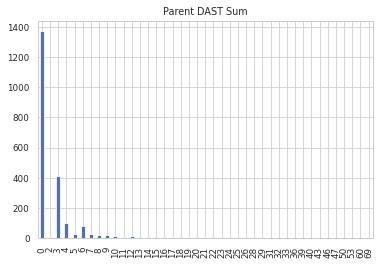

,Parent DAST Sum,Session
ID,,
1274,0,BL
22453,0,BL
75717,0,BL
106601,0,BL
106871,0,BL
...,...,...
99826568,0,BL
99873252,0,BL
99888850,0,BL


In [ ]:
df_raw_i = df_raw.filter(regex='dast_.*_sum').sum(1)
df_raw_i.name = 'Parent DAST Sum'
df_raw_i.value_counts().sort_index().plot.bar(title=df_raw_i.name)
plt.show()
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out

In [ ]:
df_out.to_csv(CONF_DATA_DIR+'all_Par_ESPADall_Par_ESPAD.csv')

##### all_PBQ
* 118 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIX_DIGEST.csv
* 119 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIX_DIGEST.csv
* 120 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIX_DIGEST.csv
* 121 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIX_DIGEST.csv
* 122 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIX_DIGEST.csv

In [487]:
#read the raw data
formulas=[]
for i, loc in enumerate([118,119,120,121,122]):
    df_raw, tp, quest, formula = get_col_raw_df(loc)
    if i>0:assert tp_old==tp and quest_old==quest
    formulas.append(formula)
    tp_old=tp
    quest_old=quest
    print(loc, quest, formula)

118 /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv sum(pbq_05a, pbq_05b, pbq_05c)
119 /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv pbq_06a
120 /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv pbq_10
121 /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv pbq_11
122 /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv pbq_12


In [488]:
df_raw_i = df_raw["pbq_05a, pbq_05b, pbq_05c".split(', ')].sum(1)
df_raw_i.name = 'Parent cigerattes during pregnancy'
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
# df_out.info()

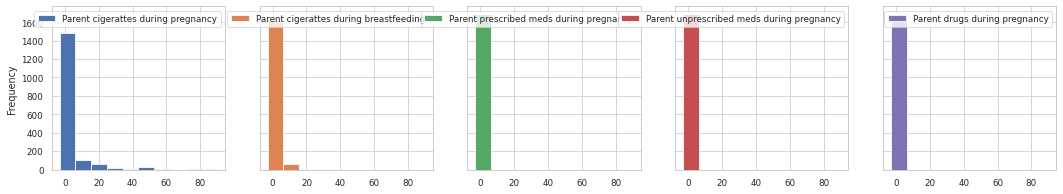

In [489]:
# now the remaining 4
other_cols = [
('Parent cigerattes during breastfeeding', 'pbq_06a'),
('Parent prescribed meds during pregnancy', 'pbq_10'),
('Parent unprescribed meds during pregnancy', 'pbq_11'),
('Parent drugs during pregnancy', 'pbq_12'),
]

for colname, cols in other_cols:
    df_out[colname] = df_raw[cols].fillna(0) #@Milena missing as 0
    
df_out.plot.hist(subplots=True, sharey=True, layout=(1,len(other_cols)+1), figsize=(4*len(other_cols)+2,3))
plt.show() # @Milena

In [492]:
df_old = pd.read_csv(CONF_DATA_DIR+'all_PBQ.csv')
df_out = pd.merge(df_old, df_out.reset_index(), on=['ID','Session'], how='outer')
df_out.set_index('ID').to_csv(CONF_DATA_DIR+'all_PBQ.csv')

##### all_Par_AUDIT
123 BL /BL/psytools/IMAGEN-IMGN_AUDIT_PARENT_RC5-BASIC_DIGEST.csv

In [509]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(123)
print(loc, quest, formula)

111 /BL/psytools/IMAGEN-IMGN_AUDIT_PARENT_RC5-BASIC_DIGEST.csv audit_total


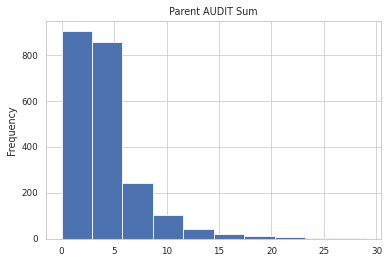

,Parent AUDIT Sum,Session
ID,,
1274,3,BL
22453,4,BL
75717,2,BL
106601,2,BL
106871,2,BL
...,...,...
99826568,0,BL
99873252,2,BL
99888850,4,BL


In [510]:
df_raw_i = df_raw["audit_total"]
df_raw_i.name = 'Parent AUDIT Sum'
df_raw_i.plot.hist(title=df_raw_i.name)
plt.show()
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out

In [511]:
df_out.to_csv(CONF_DATA_DIR+'all_Par_AUDIT.csv')

##### all_ESPAD (bully)
109 FU3 /FU3/psytools/IMAGEN-IMGN_BULLY_FU3.csv

In [565]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(109)
print(loc, quest, formula)

111 /FU3/psytools/IMAGEN-IMGN_BULLY_FU3.csv sum score 'bully': bully05 + bully06 + bully07 + bully08 + bully11 + bully12; sum score 'victim': bully01 + bully02 + bully03 + bully04 + bully09 + bully10


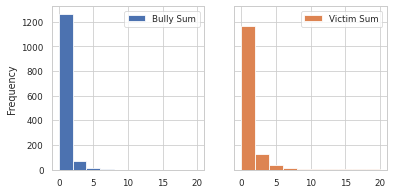

,Bully Sum,Victim Sum,Session
ID,,,
112288,0,0,FU3
215284,0,4,FU3
240546,0,2,FU3
297685,0,0,FU3
308867,0,0,FU3
...,...,...,...
99677574,0,1,FU3
99873252,0,0,FU3
99875982,0,8,FU3


In [566]:
df_raw_i = df_raw["bully05 + bully06 + bully07 + bully08 + bully11 + bully12".split(' + ')].sum(1)
df_raw_i.name = 'Bully Sum'
df_out = df_raw_i.to_frame()

df_out['Victim Sum'] = df_raw["bully01 + bully02 + bully03 + bully04 + bully09 + bully10".split(' + ')].sum(1)

df_out['Session'] = tp

df_out.plot.hist(subplots=True, sharey=True, layout=(1,2), figsize=(4+2,3))
plt.show() # @Milena
df_out

In [567]:
df_old = pd.read_csv(CONF_DATA_DIR+'all_ESPAD.csv').set_index('ID')
# df_old.loc[:,["Bully Sum","Victim Sum"]] = df_out.reset_index().set_index(['ID','Session'])
df_old.loc[df_old['Session']==tp, ["Bully Sum","Victim Sum"]] = df_out[["Bully Sum","Victim Sum"]]
df_old.to_csv(CONF_DATA_DIR+'all_ESPAD.csv')

## Main Analysis
Prepare all H5files and run the MLpipelines on 3 h5files:
1) fMRI FU3 --> FU3 binge drinking with confounds from FU3
2) fMRI BL 1 binge experience --> FU3 binge drinking with confounds from FU3 and BL
3) fMRI BL 0 binge experience --> FU3 binge drinking with confounds from FU3 and BL


### Load confounds and create h5files

In [12]:
from matplotlib.ticker import FormatStrFormatter
from sklearn.impute import KNNImputer

In [18]:
plot_dist = True
print_all = True
h5_name = 'h5causal0' # 'h5causal0' 'h5causal1', h5fu3
h5_src = H5_FILES[h5_name] 

In [22]:
# ! rm -rvf $H5_DIR/posthoc-cc2*

-------------------  (0) Alc-lastmnt   ----------------------
Using Q collected at session-BL
imputing 752/2217 missing values with 0
range (min, mean, median, max) = (0.00, 0.60, 0.00, 6.00)


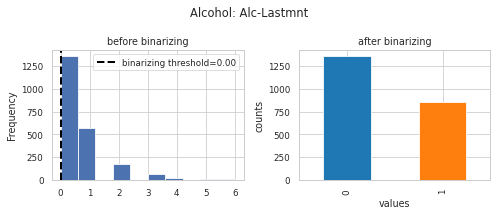

writing to .. posthoc-cc2-h5causal0-Alc-lastmnt.h5
attaching conf Alc-lastmnt
-------------------  (1) Alc-last12mnt   ----------------------
Using Q collected at session-BL
imputing 521/2217 missing values with 0
range (min, mean, median, max) = (0.00, 1.41, 1.00, 6.00)


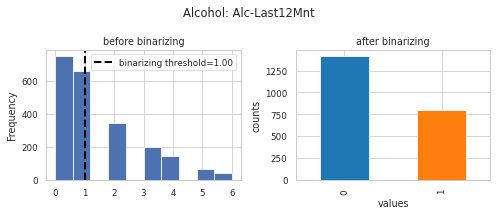

writing to .. posthoc-cc2-h5causal0-Alc-last12mnt.h5
attaching conf Alc-last12mnt
-------------------  (2) Neuroticism   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.33, 1.93, 1.92, 3.92)


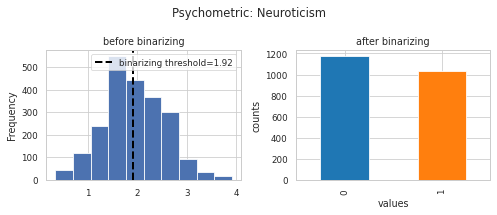

writing to .. posthoc-cc2-h5causal0-Neuroticism.h5
attaching conf Neuroticism
-------------------  (3) Extroversion   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.25, 2.50, 2.50, 3.92)


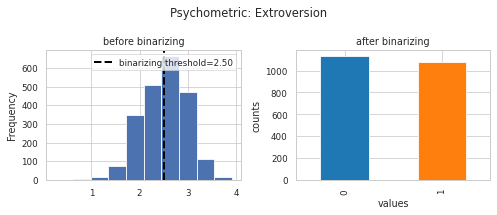

writing to .. posthoc-cc2-h5causal0-Extroversion.h5
attaching conf Extroversion
-------------------  (4) Conscientiousness   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.50, 2.30, 2.33, 4.00)


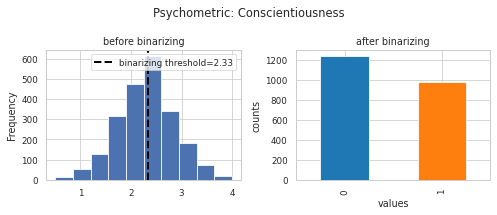

writing to .. posthoc-cc2-h5causal0-Conscientiousness.h5
attaching conf Conscientiousness
-------------------  (5) Family_freq   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.26, 0.20, 1.00)


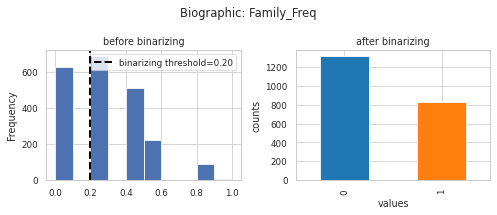

writing to .. posthoc-cc2-h5causal0-Family_freq.h5
attaching conf Family_freq
[WARN] only 471 sub IDs were found for this conf data, out of 477
Removing subjects with missing value from ['Binge', 'X', 'i', 'sex', 'site']
-------------------  (6) Family_val   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (-2.00, -1.10, -1.20, 1.60)


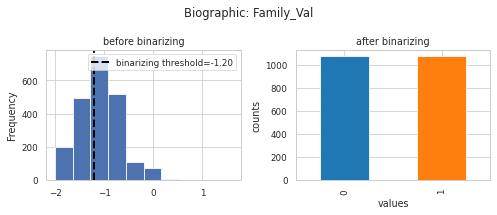

writing to .. posthoc-cc2-h5causal0-Family_val.h5
attaching conf Family_val
[WARN] only 471 sub IDs were found for this conf data, out of 477
Removing subjects with missing value from ['Binge', 'X', 'i', 'sex', 'site']
-------------------  (7) Accident_freq   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.52, 0.50, 1.00)


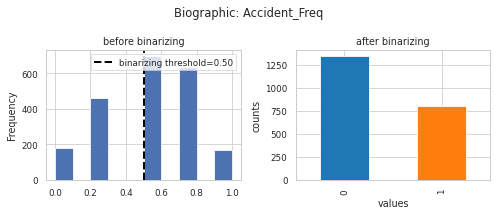

writing to .. posthoc-cc2-h5causal0-Accident_freq.h5
attaching conf Accident_freq
[WARN] only 471 sub IDs were found for this conf data, out of 477
Removing subjects with missing value from ['Binge', 'X', 'i', 'sex', 'site']
-------------------  (8) Accident_val   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (-2.00, -1.21, -1.25, 2.00)


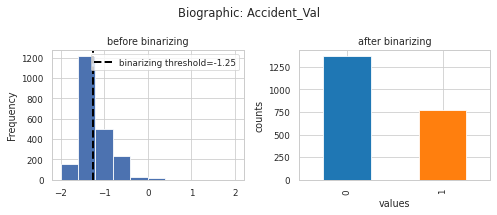

writing to .. posthoc-cc2-h5causal0-Accident_val.h5
attaching conf Accident_val
[WARN] only 471 sub IDs were found for this conf data, out of 477
Removing subjects with missing value from ['Binge', 'X', 'i', 'sex', 'site']
-------------------  (9) Sexuality_freq   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.29, 0.29, 1.00)


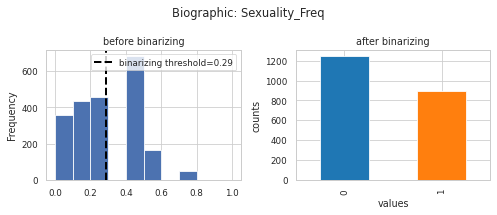

writing to .. posthoc-cc2-h5causal0-Sexuality_freq.h5
attaching conf Sexuality_freq
[WARN] only 471 sub IDs were found for this conf data, out of 477
Removing subjects with missing value from ['Binge', 'X', 'i', 'sex', 'site']
-------------------  (10) Sexuality_val   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (-1.43, -0.04, 0.00, 1.71)


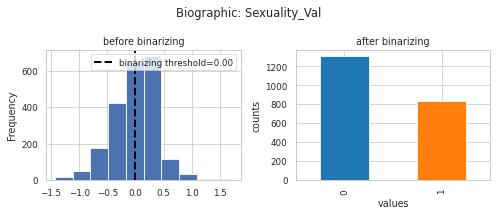

writing to .. posthoc-cc2-h5causal0-Sexuality_val.h5
attaching conf Sexuality_val
[WARN] only 471 sub IDs were found for this conf data, out of 477
Removing subjects with missing value from ['Binge', 'X', 'i', 'sex', 'site']
-------------------  (11) Autonomy_freq   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.53, 0.50, 1.00)


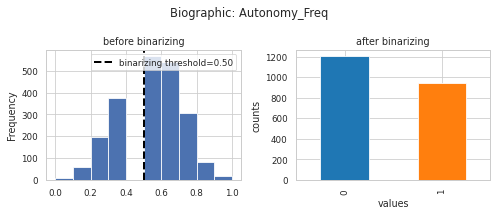

writing to .. posthoc-cc2-h5causal0-Autonomy_freq.h5
attaching conf Autonomy_freq
[WARN] only 471 sub IDs were found for this conf data, out of 477
Removing subjects with missing value from ['Binge', 'X', 'i', 'sex', 'site']
-------------------  (12) Autonomy_val   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (-1.00, 1.00, 1.00, 2.00)


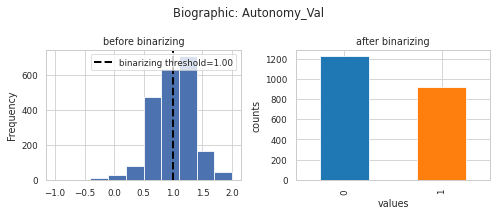

writing to .. posthoc-cc2-h5causal0-Autonomy_val.h5
attaching conf Autonomy_val
[WARN] only 471 sub IDs were found for this conf data, out of 477
Removing subjects with missing value from ['Binge', 'X', 'i', 'sex', 'site']
-------------------  (13) Deviance_freq   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.27, 0.33, 1.00)


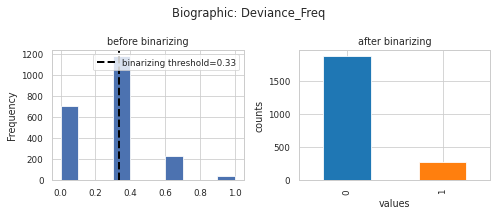

writing to .. posthoc-cc2-h5causal0-Deviance_freq.h5
attaching conf Deviance_freq
[ERROR] Failed to create h5:     the value 1 in Deviance_freq has fewer than 10% instances (n=35) which is very small for counter balancing to work
-------------------  (14) Deviance_val   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (-2.00, -1.00, -1.00, 2.00)


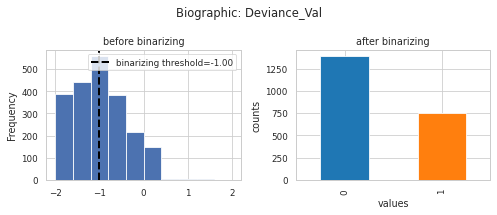

writing to .. posthoc-cc2-h5causal0-Deviance_val.h5
attaching conf Deviance_val
[WARN] only 471 sub IDs were found for this conf data, out of 477
Removing subjects with missing value from ['Binge', 'X', 'i', 'sex', 'site']
-------------------  (15) Relocation_freq   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.44, 0.33, 1.00)


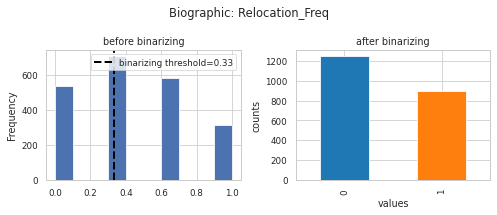

writing to .. posthoc-cc2-h5causal0-Relocation_freq.h5
attaching conf Relocation_freq
[WARN] only 471 sub IDs were found for this conf data, out of 477
Removing subjects with missing value from ['Binge', 'X', 'i', 'sex', 'site']
-------------------  (16) Relocation_val   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (-2.00, -0.38, -0.33, 2.00)


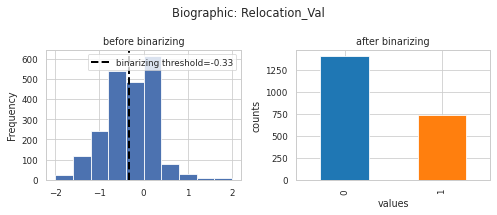

writing to .. posthoc-cc2-h5causal0-Relocation_val.h5
attaching conf Relocation_val
[WARN] only 471 sub IDs were found for this conf data, out of 477
Removing subjects with missing value from ['Binge', 'X', 'i', 'sex', 'site']
-------------------  (17) Distress_freq   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.28, 0.33, 1.00)


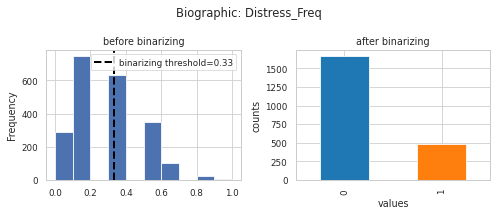

writing to .. posthoc-cc2-h5causal0-Distress_freq.h5
attaching conf Distress_freq
[WARN] only 471 sub IDs were found for this conf data, out of 477
Removing subjects with missing value from ['Binge', 'X', 'i', 'sex', 'site']
-------------------  (18) Distress_val   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (-2.00, -1.10, -1.17, 2.00)


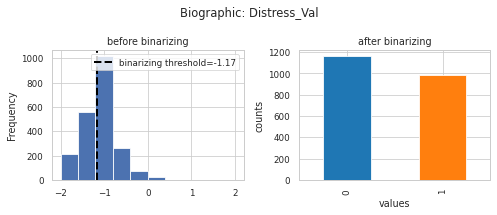

writing to .. posthoc-cc2-h5causal0-Distress_val.h5
attaching conf Distress_val
[WARN] only 471 sub IDs were found for this conf data, out of 477
Removing subjects with missing value from ['Binge', 'X', 'i', 'sex', 'site']
-------------------  (19) Total_freq   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.03, 0.37, 0.36, 0.79)


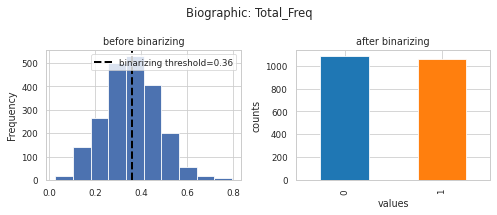

writing to .. posthoc-cc2-h5causal0-Total_freq.h5
attaching conf Total_freq
[WARN] only 471 sub IDs were found for this conf data, out of 477
Removing subjects with missing value from ['Binge', 'X', 'i', 'sex', 'site']
-------------------  (20) Total_val   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (-1.10, -0.33, -0.33, 1.59)


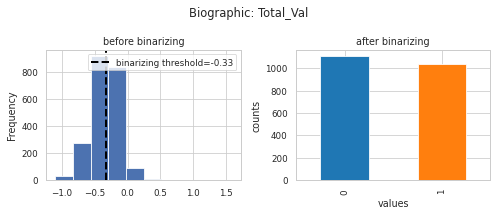

writing to .. posthoc-cc2-h5causal0-Total_val.h5
attaching conf Total_val
[WARN] only 471 sub IDs were found for this conf data, out of 477
Removing subjects with missing value from ['Binge', 'X', 'i', 'sex', 'site']
-------------------  (21) Age_first_drunk   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (11.00, 15.42, 15.00, 21.00)


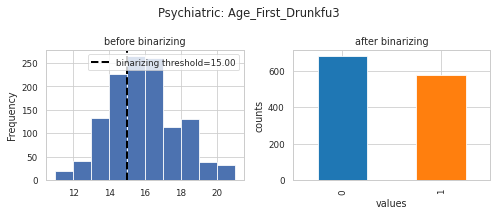

writing to .. posthoc-cc2-h5causal0-Age_first_drunkFU3.h5
attaching conf Age_first_drunkFU3
[WARN] only 418 sub IDs were found for this conf data, out of 477
Removing subjects with missing value from ['Binge', 'X', 'i', 'sex', 'site']
-------------------  (22) Drug_abuse_lft   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.00, 0.00, 0.00)


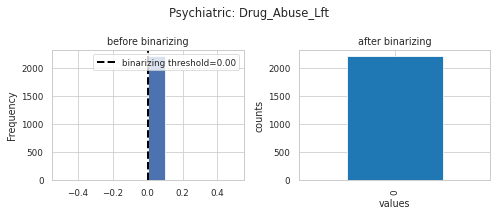

writing to .. posthoc-cc2-h5causal0-Drug_abuse_lft.h5
attaching conf Drug_abuse_lft
-------------------  (23) Nicotine_dependence   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.08, 0.00, 10.00)


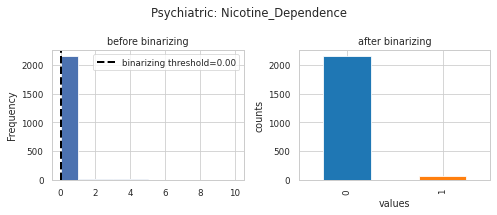

writing to .. posthoc-cc2-h5causal0-Nicotine_dependence.h5
attaching conf Nicotine_dependence
[ERROR] Failed to create h5:     the value 1 in Nicotine_dependence has fewer than 10% instances (n=2) which is very small for counter balancing to work
-------------------  (24) Comp_sub_abuse_lft   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.03, 0.00, 1.00)


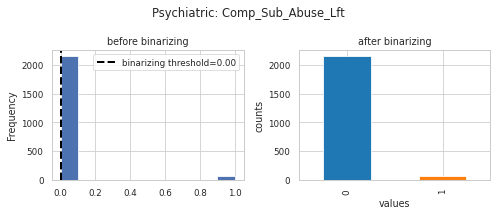

writing to .. posthoc-cc2-h5causal0-Comp_sub_abuse_lft.h5
attaching conf Comp_sub_abuse_lft
[ERROR] Failed to create h5:     the value 1 in Comp_sub_abuse_lft has fewer than 10% instances (n=2) which is very small for counter balancing to work
-------------------  (25) Novelty_seeking   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (75.00, 111.47, 111.00, 152.00)


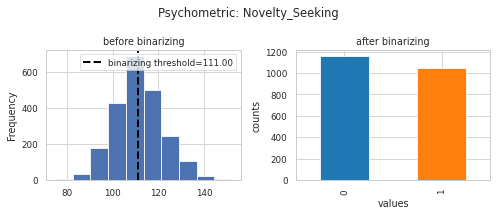

writing to .. posthoc-cc2-h5causal0-Novelty_seeking.h5
attaching conf Novelty_seeking
[WARN] only 474 sub IDs were found for this conf data, out of 477
Removing subjects with missing value from ['Binge', 'X', 'i', 'sex', 'site']
-------------------  (26) Anxiety_sensitivity   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (1.00, 2.26, 2.20, 4.00)


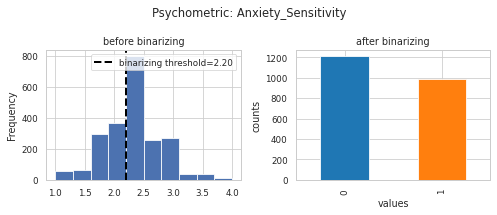

writing to .. posthoc-cc2-h5causal0-Anxiety_sensitivity.h5
attaching conf Anxiety_sensitivity
[WARN] only 476 sub IDs were found for this conf data, out of 477
Removing subjects with missing value from ['Binge', 'X', 'i', 'sex', 'site']
-------------------  (27) Hopelessness   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (1.00, 1.87, 1.86, 4.00)


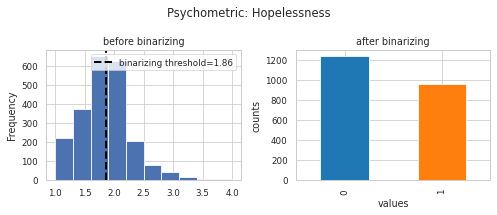

writing to .. posthoc-cc2-h5causal0-Hopelessness.h5
attaching conf Hopelessness
[WARN] only 476 sub IDs were found for this conf data, out of 477
Removing subjects with missing value from ['Binge', 'X', 'i', 'sex', 'site']
-------------------  (28) Impulsivity_SURPS   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (1.00, 2.45, 2.40, 4.00)


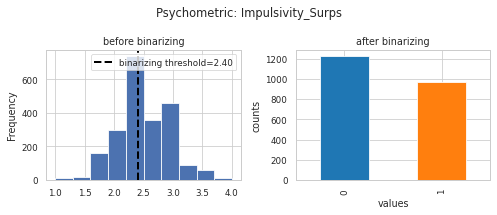

writing to .. posthoc-cc2-h5causal0-Impulsivity_SURPS.h5
attaching conf Impulsivity_SURPS
[WARN] only 476 sub IDs were found for this conf data, out of 477
Removing subjects with missing value from ['Binge', 'X', 'i', 'sex', 'site']
-------------------  (29) Sensation_seeking   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (1.00, 2.70, 2.67, 4.00)


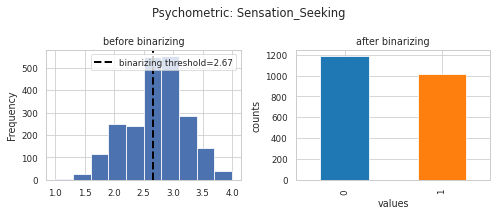

writing to .. posthoc-cc2-h5causal0-Sensation_seeking.h5
attaching conf Sensation_seeking
[WARN] only 476 sub IDs were found for this conf data, out of 477
Removing subjects with missing value from ['Binge', 'X', 'i', 'sex', 'site']
-------------------  (30) Physical_developmet   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (6.00, 23.17, 20.00, 38.00)


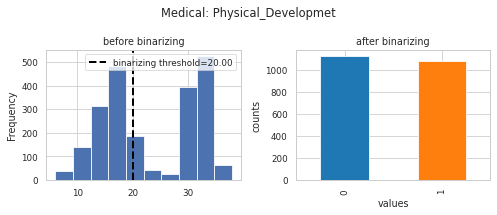

writing to .. posthoc-cc2-h5causal0-Physical_developmet.h5
attaching conf Physical_developmet
[WARN] only 476 sub IDs were found for this conf data, out of 477
Removing subjects with missing value from ['Binge', 'X', 'i', 'sex', 'site']
-------------------  (31) Bullying   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (6.00, 7.30, 6.00, 30.00)


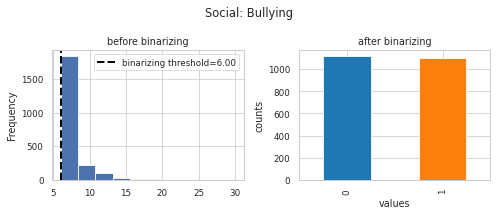

writing to .. posthoc-cc2-h5causal0-Bullying.h5
attaching conf Bullying
-------------------  (32) Bullying_victim   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (6.00, 8.16, 7.00, 30.00)


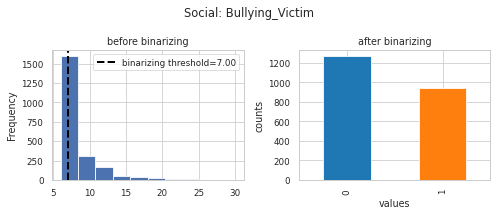

writing to .. posthoc-cc2-h5causal0-Bullying_victim.h5
attaching conf Bullying_victim
-------------------  (33) Social_behavior   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 54.18, 53.00, 122.00)


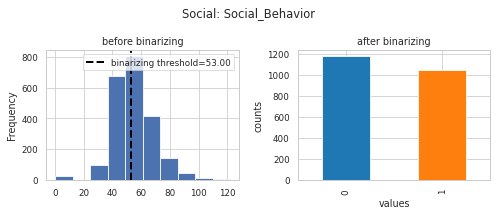

writing to .. posthoc-cc2-h5causal0-Social_behavior.h5
attaching conf Social_behavior
-------------------  (34) Alc_lastmnt_TLFB   ----------------------
Using Q collected at session-BL
imputing 36/2132 missing with K-Nearest-Neighbour algorithm
range (min, mean, median, max) = (0.00, 0.71, 0.00, 26.00)


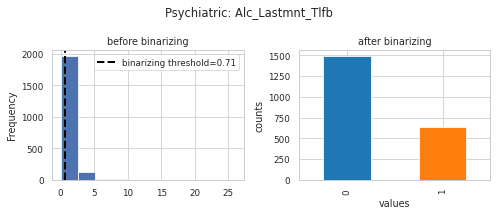

writing to .. posthoc-cc2-h5causal0-Alc_lastmnt_TLFB.h5
attaching conf Alc_lastmnt_TLFB
[WARN] only 469 sub IDs were found for this conf data, out of 477
Removing subjects with missing value from ['Binge', 'X', 'i', 'sex', 'site']
-------------------  (35) Tobacco_lastmnt_TLFB   ----------------------
Using Q collected at session-BL
imputing 69/2132 missing with K-Nearest-Neighbour algorithm
range (min, mean, median, max) = (0.00, 0.98, 0.00, 30.00)


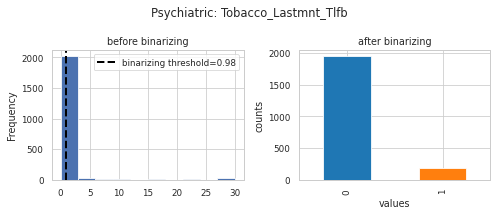

writing to .. posthoc-cc2-h5causal0-Tobacco_lastmnt_TLFB.h5
attaching conf Tobacco_lastmnt_TLFB
[ERROR] Failed to create h5:     the value 1 in Tobacco_lastmnt_TLFB has fewer than 10% instances (n=16) which is very small for counter balancing to work
-------------------  (36) Drugs_lastmnt_TLFB   ----------------------
Using Q collected at session-BL
imputing 146/2132 missing with K-Nearest-Neighbour algorithm
range (min, mean, median, max) = (0.00, 0.27, 0.00, 60.00)


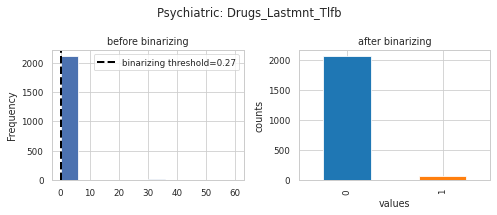

writing to .. posthoc-cc2-h5causal0-Drugs_lastmnt_TLFB.h5
attaching conf Drugs_lastmnt_TLFB
[ERROR] Failed to create h5:     the value 1 in Drugs_lastmnt_TLFB has fewer than 10% instances (n=7) which is very small for counter balancing to work
-------------------  (37) Smoking_lifetime   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.83, 0.00, 6.00)


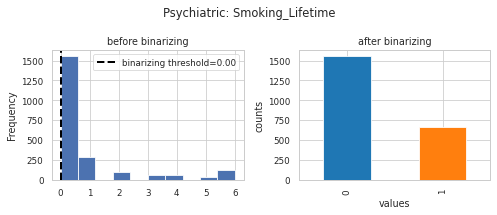

writing to .. posthoc-cc2-h5causal0-Smoking_lifetime.h5
attaching conf Smoking_lifetime
-------------------  (38) Alc-lastmnt   ----------------------
Using Q collected at session-FU3
imputing 59/1351 missing values with 0
range (min, mean, median, max) = (0.00, 2.31, 2.00, 6.00)


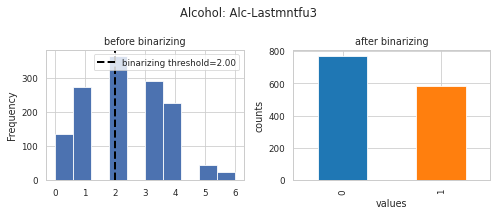

writing to .. posthoc-cc2-h5causal0-Alc-lastmntFU3.h5
attaching conf Alc-lastmntFU3
-------------------  (39) Alc-last12mnt   ----------------------
Using Q collected at session-FU3
imputing 25/1351 missing values with 0
range (min, mean, median, max) = (0.00, 4.48, 5.00, 6.00)


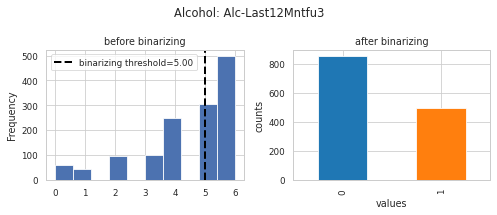

writing to .. posthoc-cc2-h5causal0-Alc-last12mntFU3.h5
attaching conf Alc-last12mntFU3
-------------------  (40) Neuroticism   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 1.77, 1.75, 4.00)


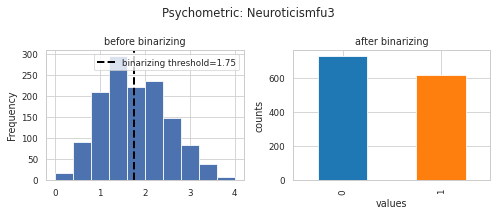

writing to .. posthoc-cc2-h5causal0-NeuroticismFU3.h5
attaching conf NeuroticismFU3
[WARN] only 475 sub IDs were found for this conf data, out of 477
Removing subjects with missing value from ['Binge', 'X', 'i', 'sex', 'site']
-------------------  (41) Extroversion   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.67, 2.40, 2.42, 3.75)


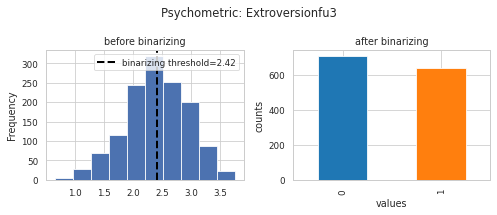

writing to .. posthoc-cc2-h5causal0-ExtroversionFU3.h5
attaching conf ExtroversionFU3
[WARN] only 475 sub IDs were found for this conf data, out of 477
Removing subjects with missing value from ['Binge', 'X', 'i', 'sex', 'site']
-------------------  (42) Conscientiousness   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.50, 2.62, 2.67, 3.92)


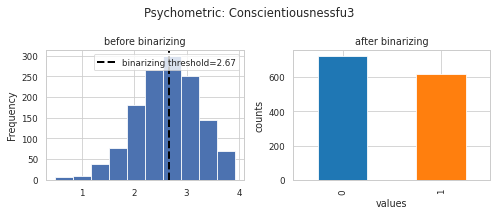

writing to .. posthoc-cc2-h5causal0-ConscientiousnessFU3.h5
attaching conf ConscientiousnessFU3
[WARN] only 475 sub IDs were found for this conf data, out of 477
Removing subjects with missing value from ['Binge', 'X', 'i', 'sex', 'site']
-------------------  (43) Anxiety_sensitivity   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (1.00, 2.34, 2.40, 4.00)


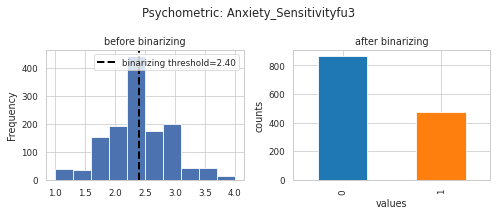

writing to .. posthoc-cc2-h5causal0-Anxiety_sensitivityFU3.h5
attaching conf Anxiety_sensitivityFU3
[WARN] only 474 sub IDs were found for this conf data, out of 477
Removing subjects with missing value from ['Binge', 'X', 'i', 'sex', 'site']
-------------------  (44) Hopelessness   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (1.43, 2.93, 2.86, 3.71)


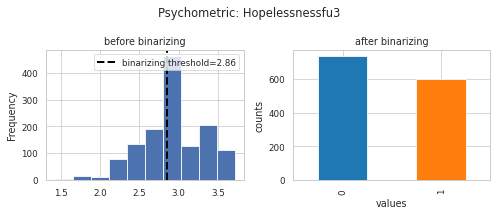

writing to .. posthoc-cc2-h5causal0-HopelessnessFU3.h5
attaching conf HopelessnessFU3
[WARN] only 474 sub IDs were found for this conf data, out of 477
Removing subjects with missing value from ['Binge', 'X', 'i', 'sex', 'site']
-------------------  (45) Impulsivity_SURPS   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (1.00, 2.13, 2.20, 4.00)


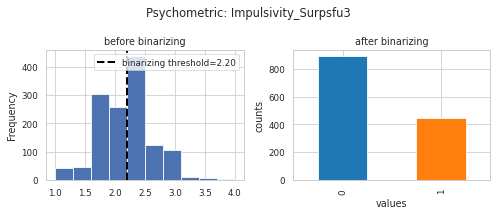

writing to .. posthoc-cc2-h5causal0-Impulsivity_SURPSFU3.h5
attaching conf Impulsivity_SURPSFU3
[WARN] only 474 sub IDs were found for this conf data, out of 477
Removing subjects with missing value from ['Binge', 'X', 'i', 'sex', 'site']
-------------------  (46) Sensation_seeking   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (1.00, 2.74, 2.83, 4.00)


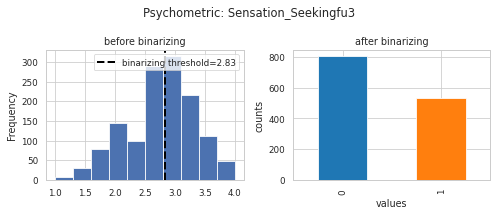

writing to .. posthoc-cc2-h5causal0-Sensation_seekingFU3.h5
attaching conf Sensation_seekingFU3
[WARN] only 474 sub IDs were found for this conf data, out of 477
Removing subjects with missing value from ['Binge', 'X', 'i', 'sex', 'site']
-------------------  (47) Drug_abuse_lft   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 0.03, 0.00, 3.00)


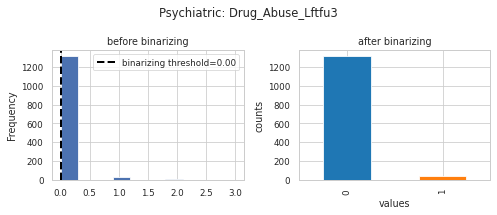

writing to .. posthoc-cc2-h5causal0-Drug_abuse_lftFU3.h5
attaching conf Drug_abuse_lftFU3
[ERROR] Failed to create h5:     the value 1 in Drug_abuse_lftFU3 has fewer than 10% instances (n=7) which is very small for counter balancing to work
-------------------  (48) Nicotine_dependence   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 0.39, 0.00, 7.00)


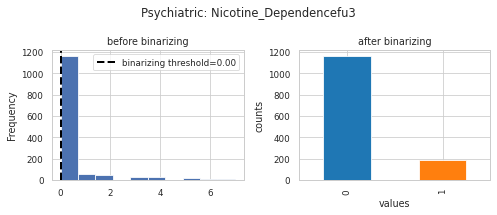

writing to .. posthoc-cc2-h5causal0-Nicotine_dependenceFU3.h5
attaching conf Nicotine_dependenceFU3
-------------------  (49) Comp_sub_abuse_lft   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 0.23, 0.00, 1.00)


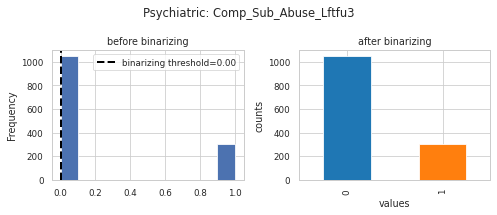

writing to .. posthoc-cc2-h5causal0-Comp_sub_abuse_lftFU3.h5
attaching conf Comp_sub_abuse_lftFU3
-------------------  (50) Smoking_lifetime   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 3.27, 4.00, 6.00)


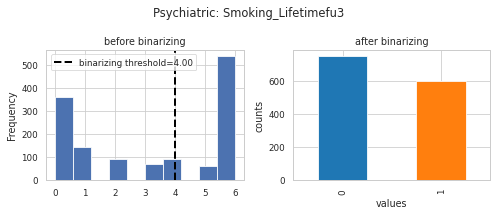

writing to .. posthoc-cc2-h5causal0-Smoking_lifetimeFU3.h5
attaching conf Smoking_lifetimeFU3
-------------------  (51) Alc_lastmnt_TLFB   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 6.03, 5.00, 30.00)


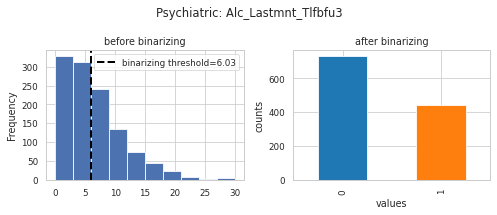

writing to .. posthoc-cc2-h5causal0-Alc_lastmnt_TLFBFU3.h5
attaching conf Alc_lastmnt_TLFBFU3
[WARN] only 391 sub IDs were found for this conf data, out of 477
Removing subjects with missing value from ['Binge', 'X', 'i', 'sex', 'site']
-------------------  (52) Tobacco_lastmnt_TLFB   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 6.46, 0.00, 30.00)


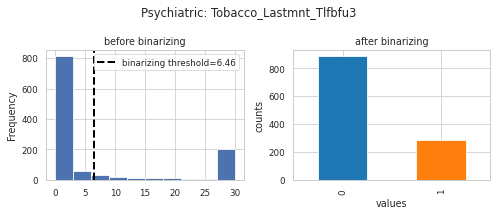

writing to .. posthoc-cc2-h5causal0-Tobacco_lastmnt_TLFBFU3.h5
attaching conf Tobacco_lastmnt_TLFBFU3
[WARN] only 391 sub IDs were found for this conf data, out of 477
Removing subjects with missing value from ['Binge', 'X', 'i', 'sex', 'site']
-------------------  (53) Drugs_lastmnt_TLFB   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 5.32, 0.00, 75.00)


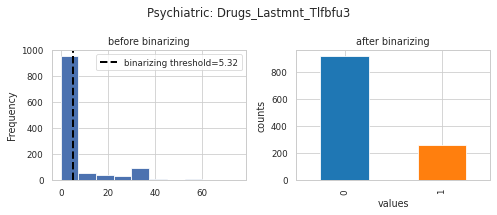

writing to .. posthoc-cc2-h5causal0-Drugs_lastmnt_TLFBFU3.h5
attaching conf Drugs_lastmnt_TLFBFU3
[WARN] only 391 sub IDs were found for this conf data, out of 477
Removing subjects with missing value from ['Binge', 'X', 'i', 'sex', 'site']
-------------------  (54) Social_drinking_motive   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 8.80, 9.00, 20.00)


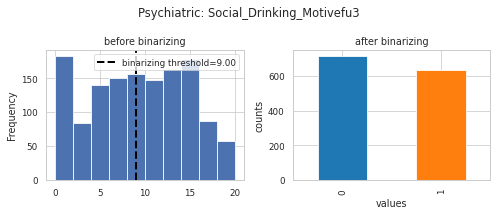

writing to .. posthoc-cc2-h5causal0-Social_drinking_motiveFU3.h5
attaching conf Social_drinking_motiveFU3
-------------------  (55) Coping_drinking_motive   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 3.15, 2.00, 20.00)


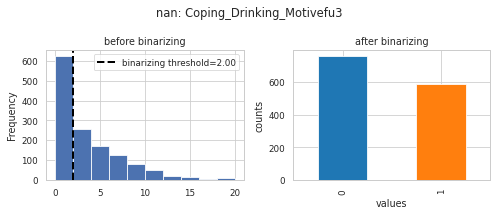

writing to .. posthoc-cc2-h5causal0-Coping_drinking_motiveFU3.h5
attaching conf Coping_drinking_motiveFU3
-------------------  (56) Enhancement_drinking_motive   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 6.12, 5.00, 20.00)


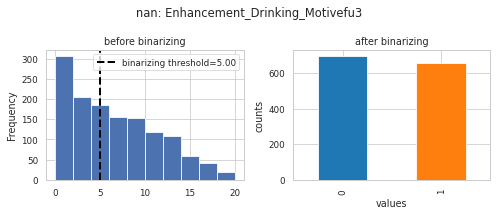

writing to .. posthoc-cc2-h5causal0-Enhancement_drinking_motiveFU3.h5
attaching conf Enhancement_drinking_motiveFU3
-------------------  (57) Conformity_drinking_motive   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 1.53, 0.00, 18.00)


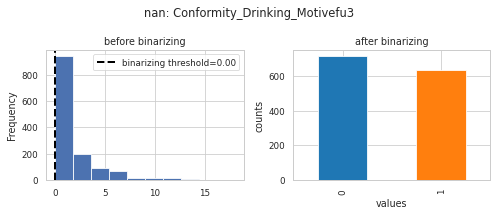

writing to .. posthoc-cc2-h5causal0-Conformity_drinking_motiveFU3.h5
attaching conf Conformity_drinking_motiveFU3
-------------------  (58) Alcohol_problem_index   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 3.51, 1.00, 42.00)


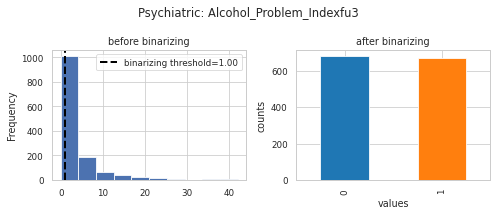

writing to .. posthoc-cc2-h5causal0-Alcohol_problem_indexFU3.h5
attaching conf Alcohol_problem_indexFU3
-------------------  (59) Somatization   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 8.18, 6.00, 63.00)


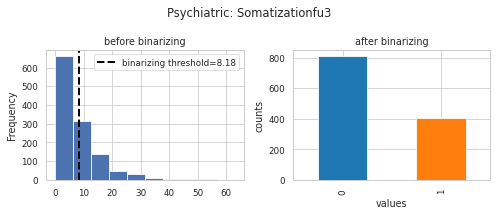

writing to .. posthoc-cc2-h5causal0-SomatizationFU3.h5
attaching conf SomatizationFU3
[WARN] only 430 sub IDs were found for this conf data, out of 477
Removing subjects with missing value from ['Binge', 'X', 'i', 'sex', 'site']
-------------------  (60) Interpers_perspective_taking   ----------------------


FileNotFoundError: [Errno 2] No such file or directory: '/ritter/share/data/IMAGEN/posthoc/all_IRI.csv'

In [23]:
for i,row in pd.read_excel("Confounds_list_Milena_v3.xlsx").iterrows():
    print(f"-------------------  ({i}) {row['conf_name']}   ----------------------")
    # load the confound from corresponding questionnaire as a pandas Series
    # print(f"From {CONF_DATA_DIR+row['questionnaire']} reading column '{row['colname']}'")
    if '???' in row["questionnaire"] or '???' in row["colname"]:
        print(f"[ERROR] {row['conf_name']} missing preprocessed tables. Extract this first.")
    else:
        
        if row['time_point'].upper()=='FU3' and 'fu3' in h5_name:
            print(f"Skipping since this is not applicable for FU3 h5file")
            continue
        
        df_conf = pd.read_csv(CONF_DATA_DIR + row["questionnaire"]).set_index('ID')
        
        if ('Session' in df_conf):
            conf = df_conf.loc[df_conf['Session']==row['time_point'], row['colname']] 
            if print_all: print(f"Using Q collected at session-{row['time_point']}")
        elif ('Session' in df_conf and df_conf['Session'].nunique()>1):
            conf = df_conf.loc[df_conf['Session']=='FU3', row['colname']] 
            if print_all: print(f"Using Q collected at session-FU3")
        else:
            conf = df_conf[row['colname']]
            if print_all: print(f"Using Q collected at session-???")

        # set the name provided 
        conf.name = row['conf_name']
        if row['time_point'] != 'BL': 
            conf.name += row['time_point']

        # impute missing values with given value
        if conf.isna().sum() and isinstance(row['impute_missing_with'], (int,float)):
            if print_all: print(f"imputing {conf.isna().sum()}/{len(conf)} missing values with {row['impute_missing_with']}")
            conf = conf.fillna(row['impute_missing_with'])
        elif conf.isna().sum():
            if print_all: print(f"imputing {conf.isna().sum()}/{len(conf)} missing with K-Nearest-Neighbour algorithm")
            # use KNN
            conf.loc[:] = KNNImputer().fit_transform(conf.values.reshape(-1, 1)).ravel()

        # plot conf distribution before binarizing
        if plot_dist:
            f, axes = plt.subplots(1,2, figsize=(7,3), sharey=False)
            plt.suptitle(f"{row['category']}: {conf.name.title()}")

            kwargs = dict(ax=axes[0],
                title="before binarizing", 
                xlabel='values', ylabel='counts')

            nunique = conf.nunique()

            conf.plot(
                kind='hist', bins=10 if nunique<100 else nunique//10,
                **kwargs)
            
            if print_all: print(
                f"range (min, mean, median, max) = ({conf.min():.2f}, {conf.mean():.2f}, {conf.median():.2f}, {conf.max():.2f})")
            
        # binarize
        binarizing_threshold = conf.median() if row['binarizing_threshold']=='median' else conf.mean()
        conf = conf.apply(lambda x: int(x>binarizing_threshold))
        
        # plot conf distribution after binarizing
        if plot_dist:
            # draw the threshold in the prev plot
            axes[0].axvline(binarizing_threshold, c='k', ls='--', lw=2, label='binarizing threshold')
            hdls, lbls = axes[0].get_legend_handles_labels()
            axes[0].legend([hdls[0]], ['binarizing threshold={:.2f}'.format(binarizing_threshold)])

            colors = [plt.get_cmap("tab10")(v) for v in sorted(conf.unique())]
            conf.value_counts(dropna=False).sort_index().plot(
                ax=axes[1], kind='bar',
                title="after binarizing", 
                xlabel='values', ylabel='counts', color=colors)
            plt.tight_layout()
            plt.show()

        # attach conf to the h5 file
        try:
            attach_conf_fromseries(H5_DIR, h5_src, conf, prepend=h5_name, print_all=print_all)
        except AssertionError as e:
            print("[ERROR] Failed to create h5:",e)
            # @Milena look at the log below for the 120+ confounds

### Check h5files

In [24]:
print("Created {} h5 files".format(len(glob(H5_DIR+f"posthoc-cc2-{h5_name}*.h5"))))

Created 54 h5 files


In [25]:
print_h5_for_MLpipeline(filter_func=lambda x: f"posthoc-cc2-{h5_name}" in x)

  DATA_DIR + 'h5files/posthoc-cc2-h5causal0-ExtroversionFU3.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5causal0-HopelessnessFU3.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5causal0-Comp_sub_abuse_lftFU3.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5causal0-Age_first_drunkFU3.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5causal0-Distress_val.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5causal0-Drug_abuse_lft.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5causal0-Alcohol_problem_indexFU3.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5causal0-Sexuality_freq.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5causal0-Coping_drinking_motiveFU3.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5causal0-Hopelessness.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5causal0-Tobacco_lastmnt_TLFBFU3.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5causal0-Sexuality_val.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5causal0-Bullying.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5causal0-Bullying_victim.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5causal0-Accident_freq.h5',
  DATA_D

In [16]:
# ! rm -rvf  $H5_DIR/posthoc-cc2-*.h5

In [17]:
# for result in sorted(glob(f"../MLpipelines/results/posthoc-cc2-*{conf.name}*/*/run.csv")):
#     df = pd.read_csv(result)
#     plot_result(df, x="test_score", no_confs=False)
#     plt.show()

### Run MLpipeline
 Add the above h5files in runMLpipelines.py, configure the appropriate settings and run it as
 `$nohup python3 runMLpipeline.py &`

### Plot results

In [358]:
df = create_accuracy_csv(h5_name)
df.Confound.nunique()

31

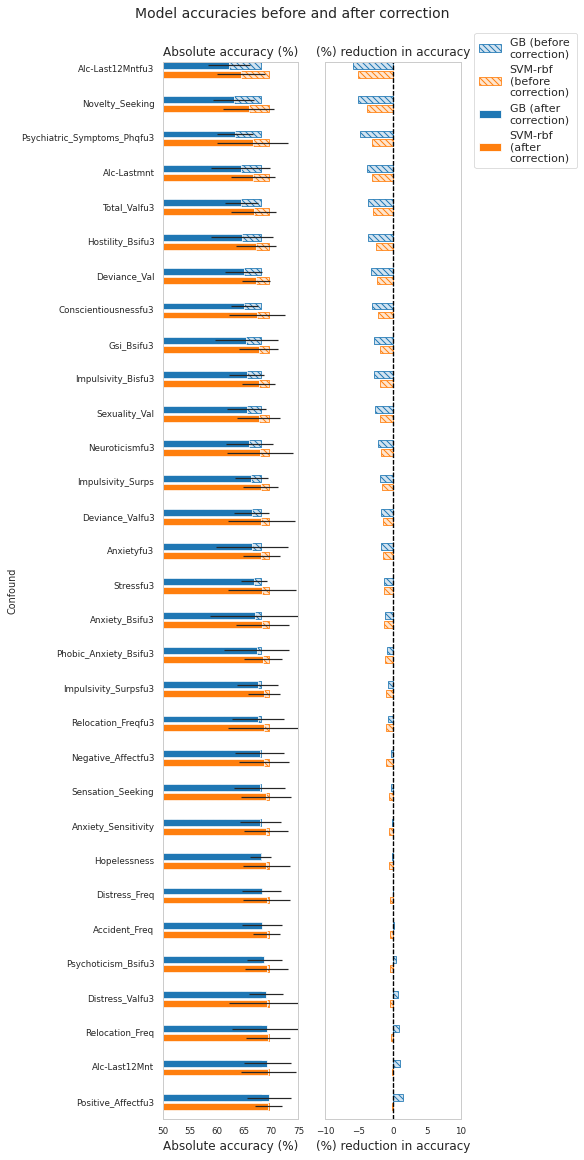

In [359]:
plot_accuracy_csv(df)
plt.savefig(f"results/results-{h5_name}.jpg")

### Next steps: 
2. Do the results generalize to test data? - repeat on holdout data
3. Are the results robust to different subsets? - repeat on FU3 and BL (full)
4. Multiple comparisons correction